In [1]:
# Imports
import os
import sys
print(sys.version)

sys.path.append('/home/pt2636/.conda/envs/final_env/lib/python3.13/site-packages')

# Primary data analysis modules
import h5py
import numpy as np
import pandas as pd

# General functionality
import math
import random
import re
import glob
from datetime import datetime

# Performance + memory checking
import time
import psutil
import resource
from tqdm import tqdm

# Scipi/Sklearn
from scipy import stats
from scipy.stats import zscore
from scipy.stats import pearsonr
from scipy.interpolate import UnivariateSpline
from scipy.spatial import Delaunay
from scipy.spatial.distance import pdist, squareform
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

# Saving data
import pickle
import json

# Plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.graph_objects as go
import trimesh
import cv2

# Parallelization + performance
from functools import partial
import itertools
from collections import Counter
import multiprocessing as mp

# Threading
import threading
from threading import Lock
from concurrent.futures import ThreadPoolExecutor


# Dan neural data analysis helper functions
sys.path.append('/mnt/smb/locker/issa-locker/users/Dan/code')
from data_analysis_tools_mkTurk.IO import ch_dicts_2_h5, h5_2_trial_df, h5_2_df, find_im_full_paths
from mkutils_ddk.IO import sessions2spikes, find_h5_path
from data_analysis_tools_mkTurk.utils_meta import find_channels, get_recording_path, get_coords_sess, get_all_metadata_sess
from data_analysis_tools_mkTurk.stim_info import filter_stim_trials, expand_classes, get_class_trials
from data_analysis_tools_mkTurk.stim_info import create_trial_df, create_stim_idx_mat, reverse_lookup_rsvp_stim
from data_analysis_tools_mkTurk.stim_info import session_dicts_2_df, sess_meta_dict_2_df
from data_analysis_tools_mkTurk.npix import chs_meta_2_site_coords, h5_2_ch_meta, get_sess_metadata_path, extract_imro_table, get_site_coords
from data_analysis_tools_mkTurk.general import df_2_psth_mat, time_window2bin_indices, remove_duplicate_rsvp_indices, rsvp_from_df

# CNNs + Image processing
from PIL import Image
import torch
import torch.optim as optim
import torch.multiprocessing as tmp
import torchvision
from torchvision import transforms
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights

# Model loading + GPU Processing function (had access issues if written in code directly)
sys.path.append('/mnt/smb/locker/issa-locker/users/Parsa/code')
sys.path.append('/scratch/issa/users/spa2139/objectome_single')
from gpu_processing import process_batch
from load_model_ver3 import load_model as load_SL_model
from objectome_single.training import BarlowTwinsLightningModule, LatentPredictionLightningModule, ObjectClassificationLightningModule

3.11.4 (main, Jul  5 2023, 14:15:25) [GCC 11.2.0]


/home/pt2636/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
Using cache found in /home/pt2636/.cache/torch/hub/facebookresearch_barlowtwins_main
/home/pt2636/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pt2636/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [2]:
print(pd.__version__)

2.3.1


In [3]:
%autosave 300

Autosaving every 300 seconds


In [4]:
# Experiments + scenefile naming conventions
'''
Expt 00 – Factorization & Scene Composition – Familiar Scene (Warehouse primary)
Expt 05 – Factorization & Scene Composition – Familiar Scene (Ballroom primary)
Expt 01 (also labelled as LX) – Learning – Novel scenes – active (freeview) vs passive (hex)
Expt 06 – Learning – Novel scenes –  deep coding (pelagic), parts integration, freeview
Expt 07 – Learning – Novel scenes – RSVP at different scene locations, freeview includes novel ID/novel position control, gaze location control
Expt 03 – OOD Faces – Manipulated Face Part Configuration – 3D & 2D – IssaDiCarlo
Expt 02 – Encoding/Decoding – Natural images & EliasNeptune – RustDiCarlo
Expt 04 – Decoding – GOR/GFR – Basel & CamelElephant, Textured vs non-textured
Expt 08 – Encoding/Decoding – HVM10

NOTE: E6_13, 14, 15 only on Bourgeois

ABC = warehouse
DEF = ballroom
both familiar, consistent

UVW - novel 
XYZ - novel
(specific to varation ##)
'''

# Runtime dictionary
process_to_runtime = {}

In [5]:
# All parameters
locker_path = '/mnt/smb/locker/issa-locker'
saved_images_dir = os.path.join(locker_path, 'Data/West/Saved_Images')
recording_dir = os.path.join(locker_path, 'users/Dan/ephys')

# Start index when splicing scenefiles (kinda bs, perhaps make better)
start_idx = 28 # based on '/mkturkfiles/scenebags/West/...'

# Can also take substrings, case insensitive
unusable_scenefiles = ['blank', 'calib', '3000']

# Unusable paths
unusable_paths = [
    '/mnt/smb/locker/issa-locker/users/Dan/ephys/West/West_20231109_R_H00_P46/20231109.h5', # less images
    '/mnt/smb/locker/issa-locker/users/Dan/ephys/West/West_20231102_R_H00_P43/20231102.h5' # less channels
]

'''
Labeled experiments:
'Rust', 'HvM',
'E7_Familiar', 'E6_Familiar'
'E6_01_Novel', 'E6_02_Novel', 'E6_05_Novel', 'E6_13_Novel', 'E6_14_Novel', 'E6_15_Novel'
'E7_01_Novel' to 'E7_08_Novel'
'''

# Analysis parameters
monkeys = ['West', 'Bourgeois']
imageset = 'HvM'
start_bin = 0
end_bin = .251
cores = 8
gpu_count = 2
notes = ''
sess_per_monkey = None # Leave as None if want all sessions

# Areas qualified as IT and MT
area_to_col = {
    'IT': ['TE0', 'TE2', 'TE3', 'channel range (IT)'],
    'MT': ['PHC', 'V2', 'V3', 'channel range (PH)', 'channel range (EC)', 'channel range (Prh)'],
    'HC': ['HC', 'channel range (HC)'],
    'TE0': ['TE0'],
    'TE2': ['TE2'],
    'TE3': ['TE3'],
}

# Shared: keep scenefiles in all dates, all: keep dates that ahve all scenefiles
keep_scenefiles = 'shared'
# Include scenefile for E6/E7 that only contains individual objects'
include_obj_sfile = False

# Split-halves calculation
ch_shr_folds = 1
min_repeat = 2 # trial per image per date
sh_limits = [.15, .2, .3] # to check
sh_limit = .3 # to use


# For decoding
dec_min_ch = 100
dec_folds = 100
dec_column = 'img_full_path'

# For area differentation
cutoffs = [8, 8.25, 8.50, 8.75, 9, 9.25, 9.5, 9.75, 10]
ch_samples = [200, 300, 400, 500, 600]
west_bour_diff = 0.25 # Bourgeois is smaller than West (compressed ML values)
rdm_shr_folds = 5
ch_rdm_shr_folds = 50

# For plotting areas
plot_sum = True

# Image cropping specifications
center_x = 1900
center_y = 1520
crop_size = 703

# Model + layer names
model_names = ['untrained_resnet50', 'resnet50', 'barlow']
layer_names = [
    'layer1.0.conv3',
    'layer1.1.conv3',
    'layer1.2.conv3',
    'layer2.0.conv3',
    'layer2.1.conv3',
    'layer2.2.conv3',
    'layer2.3.conv3',
    'layer3.0.conv3',
    'layer3.1.conv3',
    'layer3.2.conv3',
    'layer3.3.conv3',
    'layer3.4.conv3',
    'layer3.5.conv3',
    'layer4.0.conv3',
    'layer4.1.conv3',
    'layer4.2.conv3',
    'avgpool'
]

""" Last 4 conv:
        'layer4.1.conv3',
        'layer4.2.conv1',
        'layer4.2.conv2',
        'layer4.2.conv3',
"""

# Sampling of model activation layers
sample_layers = True

# Taking the max of these two values 
layer_subset_size = 1000
layer_subset_portion = 0

save_activations = False
update_neural = True # need this to be true if running all cells
activations_dir = os.path.join(locker_path, '/users/Parsa/model_activations')

'''
Greedy: 9, 9.25
Normal: 8.75, 9.5
Restrictive: 8.5, 9.75
Predicted IT: buffer
'''

# Area cutoffs to use IMPORTANT: BUFFER MUST BE GREATER THAN 2 * WEST_BOUR_DIFF
area_cutoff_dict = {
    'IT': 'labeled',
    'MT': 'labeled'
}

# Add RDM Fits for whole brain
add_whole_brain = False

# normalize by shr or plot ceilings (recommended if plotting multiple areas)
normalize_by_shr = True

# ensure equal channel counts by sampling
equal_ch_count = False

In [6]:
areas = list(area_cutoff_dict.keys())

In [7]:
# Create folder if necessary
if any(isinstance(cutoff, str) for cutoff in area_cutoff_dict.values()):
    cutoff_str = '_'.join(f'{area}{cutoff}' for area, cutoff in area_cutoff_dict.items())
else:
    cutoff_str = '_'.join(f'{area}{int(cutoff*1000)}um' for area, cutoff in area_cutoff_dict.items())
plot_dir = f'{imageset}_{cutoff_str}_{int(sh_limit*100)}chshr'
plot_dir_path = os.path.join(locker_path, 'users/Parsa/marmoset_figures', plot_dir)

# Folder save function
if not os.path.exists(plot_dir_path):
    os.makedirs(plot_dir_path)

# Find existing numbered folders inside plot_dir_path
existing_folders = glob.glob(os.path.join(plot_dir_path, '*'))

# Extract numbers from folder names
numbers = []
for folder in existing_folders:
    folder_name = os.path.basename(folder)
    if folder_name.isdigit() and len(folder_name) == 3:
        numbers.append(int(folder_name))

# Get next number (start from 000 if no numbered folders exist)
next_num = max(numbers) + 1 if numbers else 0

# Create new folder with three-digit format inside plot_dir_path
new_folder_path = os.path.join(plot_dir_path, f'{next_num:03d}')
os.makedirs(new_folder_path)

# Update plot_dir_path to point to the new subfolder
plot_dir_path = new_folder_path

In [8]:
# Files loaded, model dicts

# Load recording data csvs
bour_recording_data = pd.read_csv(os.path.join(locker_path,
                                               'users/Parsa/recording_coordinate_data',
                                               'recording coordinate data - Bourgeois.csv'))
west_recording_data = pd.read_csv(os.path.join(locker_path,
                                               'users/Parsa/recording_coordinate_data',
                                               'recording coordinate data - West.csv'))
labeled_bour_data = pd.read_csv(os.path.join(locker_path,
                                         'users/Parsa/recording_coordinate_data',
                                         'labeled brain areas - Bourgeois all recordings.csv'))
labeled_west_E6_data = pd.read_csv(os.path.join(locker_path,
                                         'users/Parsa/recording_coordinate_data',
                                         'labeled brain areas - West E6s.csv'))
labeled_west_E7_data = pd.read_csv(os.path.join(locker_path,
                                         'users/Parsa/recording_coordinate_data',
                                         'labeled brain areas - West E7s.csv'))
labeled_west_rust_data = pd.read_csv(os.path.join(locker_path,
                                                  'users/Parsa/recording_coordinate_data',
                                                  'labeled brain areas - West.csv'))

labeled_west_some_data = pd.read_csv(os.path.join(locker_path,
                                               'users/Parsa/recording_coordinate_data',
                                               'recording coordinate data - brain areas.csv'))
# Set monkey mapping for labeled areas
monkey_mapping = {
    id(labeled_west_E6_data): 'West',
    id(labeled_west_E7_data): 'West',
    id(labeled_west_rust_data): 'West',
    id(labeled_west_some_data): 'West',
    id(labeled_bour_data): 'Bourgeois'
}

labeled_data_list = [labeled_west_E6_data, labeled_west_E7_data,
                     labeled_bour_data, labeled_west_some_data,
                     labeled_west_rust_data]

bour_recording_data['monkey'] = 'Bourgeois'
west_recording_data['monkey'] = 'West'

# Set Seojin model dict, Sreyas checkpoint dict
SL_to_model = {
    'RN50_FT_8id': 'SL_resnet50_finetune_vbsle_50k_8way_far_seed77_model_best',
    'RN50_FT_8cid': 'SL_resnet50_finetune_texture_colorbg_8way_seed77_model_best',
    'RN50_FT_7em': 'SL_colorbg_resnet50_finetune_7way_EM_seojin_seed77_model_best',
    'RN50_FT_2cid_7em': 'SL_resnet50_finetune_14way_IDEM_seojin_sophie_colorbg_seed77_model_best',
    'RN50 FT_4cid_7em': 'SL_resnet50_finetune_28way_IDEM_colorbg_seed777_model_best',
    'SSRN50_FT_4id_7em': 'off_the_shelf_barlowtwins_IDEM_28way_colorbg_epochs50',
    'RN50_FT_1kBFI': 'SL_resnet50_finetune_Basel_no_texture_1000ID_seed777_model_best',
    'RN50_FT_1kcBFI': 'SL_resnet50_finetune_Basel_color_texture_1kid_seed777_model_best',
    'RN50_FT_ENept': 'SL_resnet50_finetune_vbsle_50k_elias_neptune_seed777_model_best',
    'RN50_FT_ENept_Josh': 'Josh_256bs_pretrained_model_best',
}

SBarlow_to_ckpt = {
    'objectome_bt_100': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/barlow_twins_v4/lightning_logs/20240826_143031/checkpoints/epoch=96-step=37927.ckpt',
    'objectome_bt_200': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/barlow_twins_v4/lightning_logs/20240913_153352/checkpoints/epoch=185-step=72726.ckpt',
    'fb_imagenet_bt': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/fb_pretrained_barlow_twins/fb_pretrained_bt.ckpt',
    'objectome_active_bt_100': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/active_barlow_twins/lightning_logs/20241207_153547/checkpoints/epoch=74-step=29250.ckpt',
    'objectome_active_bt_200': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/active_barlow_twins/lightning_logs/20241209_012214/checkpoints/epoch=169-step=66300.ckpt'
}

SObj_to_ckpt = {
    'objectome_scene_class': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/obj_scene_class_v2/lightning_logs/20240729_145858/checkpoints/epoch=199-step=78200.ckpt',
    'objectome_obj_class': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/obj_class_v2/lightning_logs/20240825_171308/checkpoints/epoch=72-step=57086.ckpt'
}

SLatent_to_ckpt = {
    'objectome_lp_ait_ait_100': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/latent_prediction_v3/lightning_logs/20240825_160033/checkpoints/epoch=99-step=39000.ckpt',
    'objectome_lp_ait_ait_200': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/latent_prediction_v3/lightning_logs/20240915_114623/checkpoints/epoch=159-step=62400.ckpt',
    'objectome_lp_v1_ait_100': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/latent_prediction_v3/lightning_logs/20240826_185546/checkpoints/epoch=67-step=26520.ckpt',
    'objectome_lp_ait_ait_10x_100': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/latent_prediction_v3/lightning_logs/20240918_134431/checkpoints/epoch=72-step=28470.ckpt',
    'objectome_lp_ph_ait_good_params_100': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/latent_prediction_v3/lightning_logs/20240920_175406/checkpoints/epoch=99-step=39000.ckpt',
    'objectome_lp_ait_ait_no_aug_linear_100': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/latent_prediction_no_aug/lightning_logs/20241016_142927/checkpoints/epoch=99-step=39000.ckpt',
    'objectome_lp_ait_ait_no_aug_100': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/latent_prediction_no_aug/lightning_logs/20241018_211446/checkpoints/last.ckpt-v1.ckpt',
}

all_seojin = list(SL_to_model.keys())
all_sreyas = list(SBarlow_to_ckpt.keys()) + list(SObj_to_ckpt.keys()) + list(SLatent_to_ckpt.keys())

short_seojin = ['RN50_FT_8cid', 'SSRN50_FT_4id_7em', 'RN50_FT_ENept']
short_sreyas = ['objectome_bt_100', 'objectome_lp_ph_ait_good_params_100', 'objectome_scene_class']

In [9]:
# Define memory checking functions
def check_mem():
    # Current process memory usage
    process = psutil.Process(os.getpid())
    memory_mb = process.memory_info().rss / 1024 / 1024
    print(f"Current process memory: {memory_mb:.2f} MB")
    
    # System memory info
    memory = psutil.virtual_memory()
    print(f"Total memory: {memory.total / 1024**3:.2f} GB")
    print(f"Available memory: {memory.available / 1024**3:.2f} GB")
    print(f"Memory usage: {memory.percent}%")

def check_rss():
    process = psutil.Process()
    rss_current = process.memory_info().rss / 1024**3
    print(f"Current RSS usage: {rss_current:.2f} GB")
    
    # Check the limit
    soft, hard = resource.getrlimit(resource.RLIMIT_RSS)
    print(f"RSS limit: {soft/1024**3:.2f} GB (soft), {hard/1024**3:.2f} GB (hard)")

def get_size(obj):
    size = sys.getsizeof(obj)
    if isinstance(obj, dict):
        size += sum([get_size(v) for v in obj.values()])
        size += sum([get_size(k) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i) for i in obj])
    
    return size

def check_mem_max():
    # Check various process limits
    limits_to_check = [
        (resource.RLIMIT_AS, "Virtual memory"),
        (resource.RLIMIT_DATA, "Data segment"),
        (resource.RLIMIT_RSS, "Resident set size"),
    ]
    
    for limit_type, name in limits_to_check:
        try:
            soft, hard = resource.getrlimit(limit_type)
            if soft != resource.RLIM_INFINITY:
                print(f"{name}: {soft / 1e9:.1f}GB (soft), {hard / 1e9:.1f}GB (hard)")
            else:
                print(f"{name}: Unlimited")
        except (ValueError, OSError):
            print(f"{name}: Not available on this system")

In [10]:
# Functions for retrieving paths
def find_date_in_string(text):
    match = re.search(r'\d{8}', text)
    return match.group(0) if match else None

def h5_paths(monkey, recording_dir, dates=None):
    '''
    returns paths as a list
    '''
    date_to_path = {}
    monkey_sess = os.listdir(os.path.join(recording_dir, monkey))
    paths = []
    if dates is not None:
        for date in dates:
            matching_sess = next((sess for sess in monkey_sess if date in sess), None)
            if matching_sess is not None:
                path = os.path.join(recording_dir, monkey, matching_sess, f'{date}.h5')
                if os.path.exists(path):
                    paths.append(path)
    else:
        for sess in monkey_sess:
            date = find_date_in_string(sess)
            path = os.path.join(recording_dir, monkey, sess, f'{date}.h5')
            if os.path.exists(path):
                paths.append(path)
    return paths

In [11]:
# Create combined recording data and remove no-entries in experiment column
recording_data = pd.concat((bour_recording_data, west_recording_data), join='inner')
recording_data = recording_data.loc[:, ~recording_data.columns.str.contains('Unnamed')]

# Drop experiment nans
recording_data.dropna(subset=['Expt'], inplace=True)

# Get rid of L dates (only 12 that also have E), keep Experiment dates
only_E = recording_data['Expt'].str.contains('E')&~recording_data['Expt'].str.contains('L')
recording_data = recording_data[only_E]

# Clear day1/day2 labels
recording_data.loc[:, 'Expt'] = recording_data['Expt'].str.replace(r'\s*\(.*?\)', '', regex=True).str[:5]

# Convert dates to format used by paths
convert_date = lambda x: datetime.strptime(x, '%m/%d/%Y').strftime('%Y%m%d')
recording_data['date'] = recording_data['date'].apply(convert_date)

recording_data.head()

,date,HXX,PXX,"AP, DV","dAP, dDV",angle,Hangle,Expt,config,notes,monkey
0,20241025,H00,P00,"00.0, 08.5","00.0, 00.0",89.6,0.0,E0,long,"first recording. online, IT neurons were not d...",Bourgeois
1,20241028,H00,P01,"00.0, 07.5","00.0, -01.0",89.6,0.0,E0,long,"good activity in the lower bank, possible driv...",Bourgeois
2,20241029,H00,P02,"01.0, 08.5","01.0, 00.0",89.6,0.0,E0,long,"again good activity in the lower bank, two sep...",Bourgeois
4,20241031,H00,P04,"00.0, 07.9","00.0, -00.6",50.0,0.0,E0,NaN,"new probe ( dead chs 10, 15, 18, 33?). not as ...",Bourgeois
5,20241101,H00,P05,"00.9, 08.0","00.9, -00.5",50.0,0.0,E0,NaN,sightly better activity than previous day. act...,Bourgeois


In [12]:
# Get all usable scenefiles for each experiment (expt_to_scenefiles):
expt_to_scenefiles = {}

unique_expt = sorted(list(recording_data['Expt'].unique()))

for expt, monkey in itertools.product(unique_expt, ['West', 'Bourgeois']):
    # Filter by monkey and experiment
    df = recording_data[(recording_data['Expt']==expt) & 
                        (recording_data['monkey']==monkey)].copy().reset_index()
    
    # Get h5 paths, attempt to get trial parameters
    paths = h5_paths(monkey, recording_dir, dates=list(df['date']))
    try:
        trial_params = h5_2_trial_df(paths[0])
    except:
        print(f'{expt} {monkey} has no usable h5')
        
    # Store scenefiles
    expt_to_scenefiles[expt] = list(trial_params['scenefile'].unique())

# Remove unusable scenefiles
expt_to_scenefiles = {expt: [s for s in scenefiles if not 
                             any(substring.lower() in s.lower() for substring in unusable_scenefiles)]
                      for expt, scenefiles in expt_to_scenefiles.items()}

/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda

E4 West has no usable h5


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


E6 Bourgeois has no usable h5
E6_01 West has no usable h5


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


E6_02 West has no usable h5


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


E6_05 West has no usable h5


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


E6_13 West has no usable h5


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


E6_14 West has no usable h5


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


E6_15 West has no usable h5


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda

E7_05 Bourgeois has no usable h5
E7_06 West has no usable h5
E7_07 West has no usable h5


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


E7_08 West has no usable h5


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


In [13]:
# Create imageset_to_pattern
imageset_to_pattern = {
    'Rust': r'Rust',
    'HvM': r'hvm',
    'EliasNeptune': r'elias|neptune',
    'E7_Familiar': r'1ABC17_E7_00',
    'E6_Familiar': r'(1ABC|2DEF)_(RSVP66|RSVP26)_00'
}

# Very ad hoc way of getting E7/E6 novel
for expt in expt_to_scenefiles.keys():
    E7_match = re.search(r'E7_\d{2}', expt)
    E6_match = re.search(r'E6_\d{2}', expt)
    if E7_match:
        E7_var = E7_match.group(0)
        imageset_to_pattern[f'{E7_var}_Novel'] = rf'2UVW17_{E7_var}|3UVW17_{E7_var}'
        if include_obj_sfile:
            imageset_to_pattern[f'{E7_var}_Novel'] += rf'|0ABCDEFGHIJUVW_{E7_var}'
    if E6_match:
        E6_var = E6_match.group(0)
        E6_num = E6_var[3:]
        imageset_to_pattern[f'{E6_var}_Novel'] = rf'(3UVW|4XYZ)_(RSVP66|RSVP26)_{E6_num}'
        if include_obj_sfile:
            imageset_to_pattern[f'{E6_var}_Novel'] += rf'|0ABCDEFGHIJUVWXYZ_{E6_var}'
    
scenefile_pattern = imageset_to_pattern[imageset]
print(f'Searching for: {scenefile_pattern}')

Searching for: hvm


In [14]:
# Get scenefile filtered paths
start = time.time()

# PATHS = SCENEFILE_FILTERED_PATHS (I know this is bad naming convention I just cant be bothered)
all_monkeys_paths = []
for monkey in ['West', 'Bourgeois']:
    all_monkeys_paths += h5_paths(monkey, recording_dir)

# Only keep sess that have all the scenefiles.
paths = set()
scenefiles = set()
monkeys = ['West', 'Bourgeois']
for path in all_monkeys_paths:
    try:
        trial_params = h5_2_trial_df(path)
    except:
        print(f'Could not get parameters for {find_date_in_string(path)}')
        continue
    sess_monkeys = set(trial_params['monkey'])
    sess_scenefiles = set(trial_params['scenefile'])
    for scenefile in sess_scenefiles:
        match = re.search(scenefile_pattern, scenefile)
        if match and bool(sess_monkeys & set(monkeys)):
            paths.add(path)
            scenefiles.add(scenefile)

# Turn paths into list (easier to work with)
path = list(paths)

end = time.time()
runtime = end-start
process = 'Scenefile filtering'
process_to_runtime[process] = runtime
print(f'Runtime: {runtime:.4f}s')

/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda

Runtime: 88.4750s


In [15]:
# Sample if necessary, + some other params for trial df stuff

# Remove unusable paths
paths = [path for path in paths if path not in unusable_paths]

# Sample
sampled_paths = []

if sess_per_monkey is not None:
    for monkey in monkeys:
        sampled_paths += random.sample([path for path in paths if monkey in path], sess_per_monkey)
    paths = sampled_paths

time_window = [start_bin, end_bin] # in seconds

h5_df_columns = ['monkey', 'date', 'trial_num', 'rsvp_num', 'stim_id', 'stim_idx',
       'scenefile', 'behav_file', 'img_full_path', 'psth_bins', 'source_path',
       'psth']

# Filter for only usable paths
print(f'Used sessions: {len(paths)}')

Used sessions: 14


In [16]:
# Extract session dataframes
def sess_2_df(path, scenefiles, time_window): 
    # Create filter for scenefiles
    trial_params = h5_2_trial_df(path)
    filter = trial_params.scenefile.isin(scenefiles)
    scenefile_trials = trial_params[filter]
    array_filter = np.array(scenefile_trials[['trial_num', 'rsvp_num']])
    
    # Read spike count data from HDF5 for requested trials:
    df = h5_2_df(path, trials=array_filter, time_window=time_window)
    
    # Sort df to match trial_params, rust_trials
    df.sort_index(inplace=True)
    
    return df

start = time.time()

if __name__ == "__main__":
    # Get combined dataframe for sessions
    with mp.Pool(processes=cores) as pool:
        process_session = partial(sess_2_df, scenefiles=scenefiles, time_window=time_window)
        results = pool.map(process_session, paths)
    
    # Combine all results
    combined_sess_df = pd.concat(results, ignore_index=True)
    
    combined_sess_df.shape

end = time.time()
runtime = end-start
process = 'Session extraction'
process_to_runtime[process] = runtime
print(f'Runtime: {runtime:.4f}s')

/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda

Fetching trial parameters...
Fetching trial parameters...


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


Fetching trial parameters...Fetching trial parameters...



/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


Fetching trial parameters...
Fetching trial parameters...


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


Fetching trial parameters...Fetching trial parameters...



/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


... done (0.05274844169616699 sec).... done (0.05557537078857422 sec).


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)



... done (0.055919647216796875 sec).inds_df.shape = (10500, 2)

inds_df.shape = (9114, 2)
inds_df.shape = (9258, 2)
... done (0.07569289207458496 sec).
inds_df.shape = (9018, 2)
... done (0.06835317611694336 sec).
inds_df.shape = (8562, 2)
... done (0.08559441566467285 sec).
... done (0.06765103340148926 sec).... done (0.06676530838012695 sec).inds_df.shape = (10077, 2)


inds_df.shape = (10386, 2)inds_df.shape = (10659, 2)

Pre-fetching PSTHs from HDF5...
Pre-fetching PSTHs from HDF5...
Pre-fetching PSTHs from HDF5...
Pre-fetching PSTHs from HDF5...
Pre-fetching PSTHs from HDF5...
Pre-fetching PSTHs from HDF5...
Pre-fetching PSTHs from HDF5...
Pre-fetching PSTHs from HDF5...
... done.
Duration=0.15517934958140056 minutes
Fancy slicing numpy array...
... done.
Duration=0.16101017395655315 minutes
Fancy slicing numpy array...
... done.
Duration=0.17280570268630982 minutes
Fancy slicing numpy array...
... done.
Duration=0.20316821734110516 minutes
Fancy slicing numpy array...
... done.


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


Fetching trial parameters...


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


... done (0.05447793006896973 sec).
inds_df.shape = (10500, 2)
... done.
Duration=0.10789639552434285 minutes


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


... done.
Duration=0.07177666823069255 minutes
Fetching trial parameters...


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


... done (0.12014031410217285 sec).
inds_df.shape = (9660, 2)
... done.
Duration=0.08387484153111775 minutes
Pre-fetching PSTHs from HDF5...
... done.
Duration=0.37213784058888755 minutes
Fancy slicing numpy array...
... done.
Duration=0.1013055125872294 minutes


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


Fetching trial parameters...


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


... done (0.22315001487731934 sec).
inds_df.shape = (10062, 2)


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


Pre-fetching PSTHs from HDF5...
Fetching trial parameters...


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


... done (0.1847383975982666 sec).
inds_df.shape = (9453, 2)
... done.
Duration=0.0683740774790446 minutes
Pre-fetching PSTHs from HDF5...


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


Fetching trial parameters...


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


... done (0.10839056968688965 sec).
inds_df.shape = (9378, 2)
Pre-fetching PSTHs from HDF5...


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


Fetching trial parameters...


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


... done (0.07210326194763184 sec).
inds_df.shape = (8148, 2)
Pre-fetching PSTHs from HDF5...
... done.
Duration=0.09049139817555746 minutes
Fancy slicing numpy array...
... done.
Duration=0.19642781416575114 minutes
Fancy slicing numpy array...
Pre-fetching PSTHs from HDF5...
... done.
Duration=0.15927952130635578 minutes
Fancy slicing numpy array...
... done.
Duration=0.08424139022827148 minutes
... done.
Duration=0.091591743628184 minutes
Fancy slicing numpy array...
... done.
Duration=0.08545915683110555 minutes
... done.
Duration=0.0901881217956543 minutes
Fancy slicing numpy array...
... done.
Duration=0.0776272972424825 minutes
... done.
Duration=0.17188581625620525 minutes
Fancy slicing numpy array...
... done.
Duration=0.06811985969543458 minutes
... done.
Duration=0.07088648875554403 minutes
... done.
Duration=0.06939731438954672 minutes
Runtime: 57.5268s


In [17]:
# Create + apply mask to remove nans, constant channels
nan_mask = combined_sess_df.apply(lambda x : np.any(np.isnan(x.psth)), axis=1)
final_df = combined_sess_df[-nan_mask].copy()

# Sort by scenefile
final_df.sort_values(by='scenefile', inplace=True)

print(final_df.shape)

(116159, 12)


In [18]:
# Get dates + monkey_to_dates, set prefix for images
dates = sorted(list(final_df['date'].unique()))
monkey_to_dates = {monkey: list(final_df[final_df['monkey']==monkey]['date'].unique()) for monkey in monkeys}

In [19]:
# Get paths without img_full_path using scenefile + stim_idx (scenefile...idx.png)
final_df['spliced_scenefile'] = final_df['scenefile'].str.removesuffix('.json').str[start_idx:]

def png_path_end_int(path):
    match = re.search(r'(\d+)\.png$', path)
    if match:
        return int(match.group(1))  # Returns "123" as string
    else:
        return None

def find_folder_path(root_directory, folder_name):
    for dirpath, dirnames, filenames in os.walk(root_directory):
        if folder_name in dirnames:
            return os.path.join(dirpath, folder_name)
    return None

# Generate image paths for all trials
for scenefile in final_df['spliced_scenefile'].unique():
    sfile_path = find_folder_path(saved_images_dir, scenefile)
    img_list = os.listdir(sfile_path)
    # Note: there is one .json in each scenefile, which is mapped to None in dict
    idx_to_path = {png_path_end_int(img):'/'.join([sfile_path, img]) 
                   for img in img_list if img.endswith('.png')}
    scene_mask = final_df['spliced_scenefile'] == scenefile
    final_df.loc[scene_mask, 'img_full_path'] = final_df.loc[scene_mask, 'stim_idx'].map(idx_to_path)

print(f'Unique images: {final_df.img_full_path.unique().shape[0]}')

Unique images: 450


In [20]:
# Find dates that dont have all scenefiles
incomplete_scenefile_dates = []
scenefile_sets = []
unique_sfile = set(final_df['spliced_scenefile'])

for date in dates:
    sfile_series = final_df[final_df['date']==date]['spliced_scenefile']
    scenefile_sets.append(set(sfile_series))
    if set(sfile_series)!=unique_sfile:
        print(f'{date} does not have all necessary scenefiles')
        incomplete_scenefile_dates.append(date)
        
if not incomplete_scenefile_dates:
    print('All dates have necessary scenefiles')
else:
    shared_scenefiles = unique_sfile.intersection(*scenefile_sets)
    print(f'Shared scenefiles: {list(shared_scenefiles)}')

All dates have necessary scenefiles


In [21]:
# Filter dates s.t. all have same scenefiles
if keep_scenefiles=='all' and incomplete_scenefile_dates:
    final_df = final_df[~final_df['date'].isin(incomplete_scenefile_dates)]
    dates = [date for date in dates if date not in incomplete_scenefile_dates]
    print('Eliminated all dates that are missing scenefiles')
elif keep_scenefiles=='shared' and incomplete_scenefile_dates:
    final_df = final_df[final_df['spliced_scenefile'].isin(shared_scenefiles)]
    print('Eliminated all scenefiles that are missing in some dates')

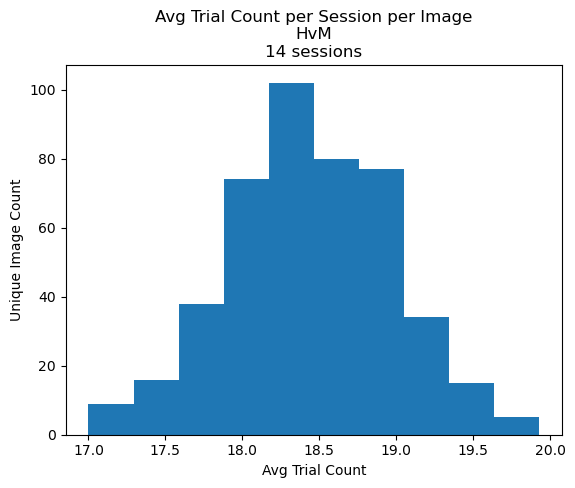

In [22]:
# Get trial counts
trial_counts = (final_df.groupby(['img_full_path', 'date'])
                .size()
                .groupby('img_full_path')
                .mean()
                .tolist())
plt.hist(trial_counts)
plt.title(f'Avg Trial Count per Session per Image\n{imageset}\n{len(dates)} sessions')
plt.xlabel('Avg Trial Count')
plt.ylabel('Unique Image Count')
plt.savefig(os.path.join(plot_dir_path, 'trial_counts.png'))
plt.show()

In [23]:
def ch_shr(ch_data, path_list, min_repeats):
    ''' Gets the split-halves reliability for a single channel

    Args:
        ch_data (n by 1 array): ordered channel activity
        path_list: ordered image paths
        min_repeats: minimum repetitions required for an image to be used
        labels: optional alternate labels to use in calculations, default=None --> image paths

    Returns:
        shr: split-halves reliability
        count_arr: matrix of max repetitions x image for the channel
    '''
    # ch_data --> count_arr using path_list
    path_counts = Counter(path_list)
    valid_paths = [path for path, count in path_counts.items() if count >= min_repeats]
    unique_imgs = set(valid_paths)
    img_count = len(unique_imgs)
    max_reps = max(path_counts[path] for path in valid_paths)
    count_arr = np.full((max_reps, img_count), np.nan)
    for unique_img_idx, path in enumerate(unique_imgs):
        idx_list = [i for i, j in enumerate(path_list) if j == path]
        np.random.shuffle(idx_list) # NOTE RANDOMNESS INTRODUCED!
        reps = len(idx_list)
        count_arr[:reps, unique_img_idx] = ch_data[idx_list]
    
    # Find SHR using count_arr
    neuron_1, neuron_2 = count_arr[::2], count_arr[1::2]
    neuron_1_avg = np.nanmean(neuron_1, axis=0)
    neuron_2_avg = np.nanmean(neuron_2, axis=0)
    shr, _ = stats.pearsonr(neuron_1_avg, neuron_2_avg)

    return shr, count_arr

In [ ]:
# Calculate SHRs:

trial_avg_list = []
date_to_reliable_ch = {}
date_to_sh = {}

def process_fold_channel(args):
    """Process a single fold-channel pair"""
    fold, ch, marm_avg_spikes, natimg_path_list, min_repeat = args
    shr, count_arr = ch_shr(marm_avg_spikes[:, ch], natimg_path_list, min_repeat)
    return fold, ch, shr

start = time.time()

for date in final_df.date.unique():
    print(f'Date: {date}')
    
    # Convert psth to spike matrix, sort by stim_idx to match other pens
    date_df = final_df[final_df['date'] == date].copy()
    date_df.sort_values(by='stim_idx', inplace=True)
    
    # Extract spikes, check for nan
    final_spike_arr = np.array(list(date_df.psth))
    
    # Create avg_spikes, zscore
    avg_spikes = np.mean(final_spike_arr, axis=2)
    marm_avg_spikes = zscore(avg_spikes.astype('float32'), axis=1)
    
    # Get natimg_path_list
    natimg_path_list = date_df['img_full_path'].tolist()
    
    # Find max_reps
    trial_counts = []
    for path in set(natimg_path_list):
        trial_counts.append(natimg_path_list.count(path))
    max_reps = max(trial_counts)
    
    # Set data parameters, folds, min_repeat
    ch_tot = marm_avg_spikes.shape[1]
    stim_tot = marm_avg_spikes.shape[0]
    
    # Get sh, img_spikes_tot
    sh_data = np.zeros(ch_tot)
    unique_img_count = len(set(natimg_path_list))    
    shr_arr = np.zeros((ch_shr_folds, ch_tot))
    
    # Create args list for parallel processing
    args_list = [(fold, ch, marm_avg_spikes, natimg_path_list, min_repeat)
                 for fold, ch in itertools.product(range(ch_shr_folds), range(ch_tot))]

    # Get SHR, parallel across fold-channel pairs
    with mp.Pool(processes=cores) as pool:
        results = pool.map(process_fold_channel, args_list)
    
    # Save values
    for fold, ch, shr in results:
        shr_arr[fold, ch] = shr
    
    sh_data = np.mean(shr_arr, axis=0)
    date_to_sh[date] = sh_data

end = time.time()
runtime = end-start
process = 'SHR calculation'
process_to_runtime[process] = runtime
print(f'Runtime: {runtime:.4f}s')

In [ ]:
# Check impact of different SH_Limits
sh_limit_to_date_to_ch = {}

for sh_limit in sh_limits:
    print(f'SH Cutoff: {sh_limit}')
    total_good_ch = 0
    sh_list = []
    date_to_reliable_ch = {}
    for date in final_df.date.unique():
        sh_data = date_to_sh[date]
        good_ch = np.where(sh_data >= sh_limit)[0]
        good_ch_count = good_ch.shape[0]
        total_good_ch += good_ch_count
        #print(f'{date} ch above {sh_limit}: {good_ch_count}')
        good_sh = sh_data[good_ch]
        sh_list.append(good_sh)
        date_to_reliable_ch[date] = good_ch
    
    avg_shr = np.hstack(sh_list).mean()
    print(f'{sh_limit} average SHR: {avg_shr:.4f}')
    print(f'Reliable channels: {sum(len(ch_arr) for ch_arr in date_to_reliable_ch.values())}')
    sh_limit_to_date_to_ch[sh_limit] = date_to_reliable_ch

In [ ]:
# Choose SH limit accordingly
print(f'Chosen SH Cutoff: {sh_limit}')
total_good_ch = 0
sh_list = []
for date in final_df.date.unique():
    sh_data = date_to_sh[date]
    good_ch = np.where(sh_data >= sh_limit)[0]
    good_ch_count = good_ch.shape[0]
    total_good_ch += good_ch_count
    good_sh = sh_data[good_ch]
    sh_list.append(good_sh)
    date_to_reliable_ch[date] = good_ch

avg_shr = np.hstack(sh_list).mean()
print(f'{sh_limit} average SHR: {avg_shr:.4f}')
print(f'Reliable channels: {sum(len(ch_arr) for ch_arr in date_to_reliable_ch.values())}')

In [29]:
'''
Need to make this trial averaged
'''

'\nNeed to make this trial averaged\n'

In [ ]:
# Get decoding score:
print(f'Calculating {dec_column} decoding scores...')

def decoding_score(neural, labels, folds=10):
    unique_img_count = np.unique(labels).shape[0]
    chance = 1/unique_img_count
    scores = np.zeros(folds)
    
    for fold in range(folds):
        neural_train, neural_test, labels_train, labels_test = train_test_split(
            neural, labels, test_size=0.8, stratify=labels
        )
        model = LinearRegression()
        model.fit(neural_train, labels_train)
        labels_pred = model.predict(neural_test)
        labels_final = np.round(labels_pred).astype(int)
        scores[fold] = accuracy_score(labels_test, labels_final)
    avg_score = np.mean(scores)/chance
    return avg_score

date_to_decode = {}
for date in dates:
    date_df = final_df[final_df['date']==date]
    if date_to_reliable_ch[date].size < dec_min_ch:
        print(f'{date} has < {dec_min_ch} reliable channels')
        continue
    neural = np.stack(date_df['psth'].values).mean(axis=2)[:, date_to_reliable_ch[date]]
    labels = LabelEncoder().fit_transform(list(date_df[dec_column]))
    dec_score = decoding_score(neural, labels, folds=dec_folds)
    print(f'{date}: {dec_score:.4f} decode score')
    date_to_decode[date] = dec_score

if len(date_to_decode) > 0:
    avg_dec_score = sum(date_to_decode.values())/len(date_to_decode.values())
    print(f'Average {dec_column} decoding score: {avg_dec_score:.4f}')
else:
    avg_dec_score = 0
    print(f'No dates have >= {dec_min_ch} reliable channels')

In [ ]:
# Get all possible data for coordinate visualization + interpolation

# Get list of all dates for each monkey. Plot all labeled coordinates.
monkey_to_all_dates = {monkey: [find_date_in_string(path) 
                                for path in h5_paths(monkey, recording_dir)]
                        for monkey in monkeys}

# Get site coordinate info
site_coords_list = []

def get_site_coords_df(monkey, date):
    # Get path
    path = h5_paths(monkey, recording_dir, dates=[date])[0]
    
    try:
        # Get base metadata:
        zero_coords, imro_df = h5_2_ch_meta(path) # (invoked from directory contianing .h5)
    except:
        base_data_path = '/mnt/smb/locker/issa-locker/Data'
        # get zero coords + imro table
        zero_coords = get_coords_sess(base_data_path, monkey, date)
        glx_meta_path = get_sess_metadata_path(base_data_path, monkey, date)
        imro_df = extract_imro_table(glx_meta_path)
    
    # Add stuff:
    imro_df['monkey'] = monkey
    imro_df['date'] = date
    imro_df['ch_idx_glx'] = np.arange(384)
    zero_coords_df = pd.DataFrame(zero_coords).T # Convert from dict to dataframe
    zero_coords_df['monkey'] = monkey
    zero_coords_df['date'] = date
    
    # Compute site coordinates:
    return chs_meta_2_site_coords(zero_coords_df, imro_df)

start = time.time()

for monkey, monkey_dates in monkey_to_all_dates.items():
    for date in monkey_dates:
        try:
            site_coords_list.append(get_site_coords_df(monkey, date))
            print(f'{date} WORKED!')
        except:
            print(f'{date} did not work.')
    
site_coords = pd.concat(site_coords_list, ignore_index=True)

end = time.time()
runtime = end-start
process = 'Site coordinate info'
process_to_runtime[process] = runtime
print(f'Runtime: {runtime:.4f}s')

In [ ]:
# Create dataframe for Ashley's labels
ch_range_pattern = r'(\d+)-(\d+)'
hole_pattern = r'(H\d{2})'
pen_pattern = r'(P\d{2})'

ch_area_ranges = pd.DataFrame(columns=['hole', 'pen_id', 'monkey']+areas)

for labeled_df in labeled_data_list:
    monkey = monkey_mapping[id(labeled_df)]
    df = labeled_df.copy()
    df = df[df.astype(str).apply(lambda row: row.str.contains(ch_range_pattern, regex=True).any(), axis=1)]
    
    def extract_ranges(row, columns):
        ranges = []
        for col in columns:
            if col in row.index:
                matches = re.findall(r'(\d+)-(\d+)', str(row[col]))
                ranges.extend([(int(start), int(end)) for start, end in matches])
        if not ranges:
            return None
        
        # Sort ranges by start position
        ranges = [sorted(r) for r in ranges]
        
        # Return as string format
        return ranges  #f'{ranges[0][0]}-{ranges[-1][1]}'
    
    for area in areas:
        df[area] = df.apply(lambda row: extract_ranges(row, area_to_col[area]), axis=1)
    if 'penetration' in df.columns:
        df['hole'] = df['penetration'].str.extract(hole_pattern)
        df['pen_id'] = df['penetration'].str.extract(pen_pattern)
    elif 'HXX, PXX' in df.columns:
        df['hole'] = df['HXX, PXX'].str.extract(hole_pattern)
        df['pen_id'] = df['HXX, PXX'].str.extract(pen_pattern)
    df['monkey'] = monkey
    ch_area_ranges = pd.concat([df[['hole', 'pen_id', 'monkey']+areas], ch_area_ranges], ignore_index=True)

In [ ]:
# Filter out sessions missing pen info or no relevant labels, delete duplicates

# Note: keeping the first instance (from labeled_brain_areas)
og_sess_count = ch_area_ranges.shape[0]
ch_area_ranges = ch_area_ranges.dropna(subset=['hole', 'pen_id'])
ch_area_ranges = ch_area_ranges.dropna(subset=areas, how='all')
ch_area_ranges= ch_area_ranges.drop_duplicates(subset=['hole', 'pen_id', 'monkey'], keep='first')
print(f'Removed {og_sess_count-ch_area_ranges.shape[0]} sessions, left with {ch_area_ranges.shape[0]}')

In [ ]:
# Expand channel ranges to match ch_idx_depth column of all_site_coords
# Note: Assuming ashley is marking by depth
labeled_df_list = []

for area in areas:
    fixed_df = ch_area_ranges[-ch_area_ranges[area].isnull()][['hole', 'pen_id', 'monkey', area]]
    df = fixed_df.explode([area])
    df['ch_idx_depth'] = df[area].apply(lambda x: list(range(x[0], x[1] + 1)))
    
    # Explode the expanded indices, sort
    ch_area_idx = df.drop(area, axis=1).explode('ch_idx_depth')
    ch_area_idx.sort_values(by=['hole', 'pen_id', 'monkey'], inplace=True)
    
    # Add area
    ch_area_idx['area'] = area
    
    labeled_df_list.append(ch_area_idx)
    
labeled_ch_df = pd.concat(labeled_df_list, ignore_index=True)

In [ ]:
# Create new combined recording data (includes more sessions, less filtering)
all_recording_data = pd.concat((bour_recording_data, west_recording_data), join='inner')

# Remove no-entries in experiment column
all_recording_data = all_recording_data.loc[:, ~all_recording_data.columns.str.contains('Unnamed')]

# Format dates
formatted_dates = pd.to_datetime(all_recording_data['date'], format='%m/%d/%Y', errors='coerce')
all_recording_data = all_recording_data[formatted_dates.notna()]
convert_date = lambda x: datetime.strptime(x, '%m/%d/%Y').strftime('%Y%m%d')
all_recording_data['date'] = all_recording_data['date'].apply(convert_date)

# Rename HXX to hole and PXX to pen_id to match remaining dataframes
all_recording_data.rename(columns={'HXX': 'hole', 'PXX': 'pen_id'}, inplace=True)

# Filter for usable hole and pen_id
all_recording_data = all_recording_data[all_recording_data['hole'].notna()&
                                        all_recording_data['pen_id'].notna()]

In [ ]:
graph_labels=True
def plot_dates_on_timeline(date_strings):
    """
    Plots a list of dates (in yyyymmdd format) on a timeline using Pandas and Matplotlib.
    """
    if not date_strings:
        print("No dates to plot.")
        return

    # Create a Pandas Series of dates, automatically parsing
    s = pd.to_datetime(pd.Series(date_strings), format='%Y%m%d', errors='coerce')
    s = s.dropna() # Drop any dates that failed to parse

    if s.empty:
        print("No valid dates to plot after parsing.")
        return

    s = s.sort_values() # Sort the dates

    plt.figure(figsize=(12, 6))
    plt.hist(s, bins='auto', edgecolor='black', alpha=0.7, color='teal')

    plt.title('Distribution of Dates')
    plt.xlabel('Date')
    plt.ylabel('Frequency')

    # Format x-axis for dates
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    plt.gcf().autofmt_xdate() # Rotate and align labels

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [ ]:
# Get intersections + set up df
if graph_labels:
    '''
    Get intersections of labeled sessions, site coordinate sessions
    '''
    
    # rename
    all_recording_data.rename(columns={'HXX': 'hole', 'PXX': 'pen_id'}, inplace=True)
    
    # df1: labeled
    df1 = labeled_ch_df[['hole', 'pen_id', 'monkey']].drop_duplicates()
    # df2: site coords
    df2 = site_coords.merge(all_recording_data[['date', 'hole', 'pen_id']], on='date').drop_duplicates(subset=['date'])
    
    df1['monkey_hole_pen_id'] = df1['monkey'] + '_' + df1['hole'] + '_' + df1['pen_id']
    df2['monkey_hole_pen_id'] = df2['monkey'] + '_' + df2['hole'] + '_' + df2['pen_id']
    no_coords_labeled = df1[~df1['monkey_hole_pen_id'].isin(df2['monkey_hole_pen_id'])]
    no_coords_labeled = no_coords_labeled.merge(all_recording_data, on=['monkey', 'hole', 'pen_id'])
    print(f'Number of sessions labeled without coordinate data: {len(no_coords_labeled)}')
    
    # Plot dates on timeline
    plot_dates_on_timeline(list(no_coords_labeled.date.unique()))

In [ ]:
# Merge with site coords and recording data to add hole, pen_id
ch_coords = labeled_ch_df.merge(site_coords.merge(all_recording_data[['date', 'hole', 'pen_id']], on='date'), 
                                    on=['hole', 'pen_id', 'monkey', 'ch_idx_depth'], how='left')

# Remove nans
ch_coords = ch_coords.dropna(subset=['ch_idx_glx'])
ch_coords['ch_idx_glx'] = ch_coords['ch_idx_glx'].astype('int')

coordinates = ['ml', 'dv', 'ap']

coord_info = []
for area in areas:
    df = ch_coords[ch_coords['area']==area]
    for date in df.date.unique():
        date_df = df[df['date']==date]
        monkey = date_df.monkey.unique()
        x = pd.DataFrame({'monkey': monkey, 
                          'area': area,
                          'date': date,
                          'ml_start': min(date_df.ml.values),
                          'ml_end': max(date_df.ml.values),
                          'dv_start': min(date_df.dv.values),
                          'dv_end': max(date_df.dv.values),
                          'ap_start': min(date_df.ap.values),
                          'ap_end': max(date_df.ap.values)})
        coord_info.append(x)
sess_coords = pd.concat(coord_info)

# Create monkey-area combinations
sess_coords['monkey_area'] = sess_coords['monkey'] + '_' + sess_coords['area']

In [64]:
### SKIP IF GRAPH_LABELS IS FALSE

In [ ]:
plot_areas = ['TE0']
plot_area = 'TE0'

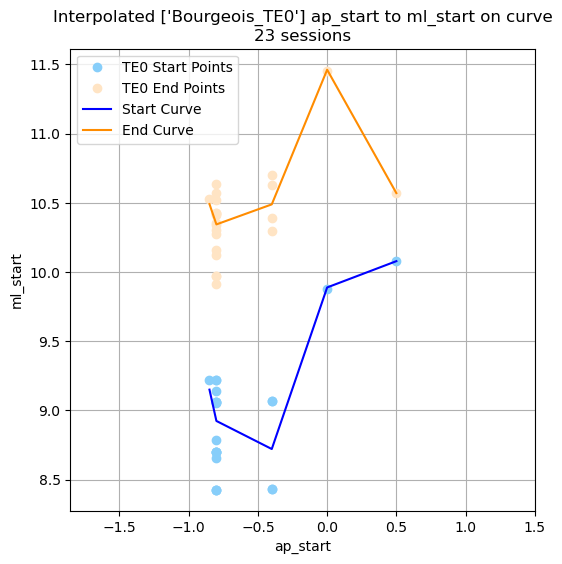

In [134]:
# Plot interpolated areas
if graph_labels:
    monkey_to_start_spline = {}
    for monkey in ['Bourgeois']:#monkeys
        '''
        Plot interpolated curves for start IT and stop IT
        '''
        monkey_areas = [f'{monkey}_{plot_area}']
        x_start = 'ap_start'
        y_start = 'ml_start'
        x_end = 'ap_end'
        y_end = 'ml_end'
        
        # Get unique combinations and assign colors
        unique_combinations = sess_coords['monkey_area'].unique()
        colors = plt.cm.Set3(np.linspace(0, 1, len(unique_combinations)))
        color_map = dict(zip(unique_combinations, colors))
        
        df_filt = sess_coords[sess_coords['monkey_area'].isin(monkey_areas)]
        sess_count = len(df_filt.date.unique())
        df_start_avg = df_filt.groupby(x_start, as_index=False)[y_start].mean()
        df_end_avg = df_filt.groupby(x_end, as_index=False)[y_end].mean()
        df_avg = df_start_avg.join(df_end_avg).dropna() # remove nans
        
        df_start_curve_sorted = df_avg.sort_values(by=x_start)
        df_end_curve_sorted = df_avg.sort_values(by=x_end)
        
        start_spline = UnivariateSpline(df_start_curve_sorted[x_start], df_start_curve_sorted[y_start], s=7)
        end_spline = UnivariateSpline(df_end_curve_sorted[x_end], df_end_curve_sorted[y_end], s=7)
        
        monkey_to_start_spline[monkey] = start_spline
        
        plt.figure(figsize=(6, 6))
        plt.plot(df_filt[x_start], df_filt[y_start], 'o', c='lightskyblue', label=f'{area} Start Points')
        plt.plot(df_filt[x_end], df_filt[y_end], 'o', c='bisque', label=f'{area} End Points')
        
        '''
        # Plot MT ranges to check if they are selected against
        df_mt_filt = sess_coords[sess_coords['monkey_area'].isin(monkey_mt_areas)]
        plt.plot(df_mt_filt[x_start], df_mt_filt[y_start], 'o', c='lightgreen', label='MT Start Points')
        plt.plot(df_mt_filt[x_end], df_mt_filt[y_end], 'o', c='darkseagreen', label='MT End Points')
        '''
        
        # start, stop curve
        plt.plot(df_start_curve_sorted[x_start], 
                 start_spline(df_start_curve_sorted[x_start]), '-', c='blue', label='Start Curve')
        plt.plot(df_end_curve_sorted[x_end], 
                 end_spline(df_end_curve_sorted[x_end]), '-', c='darkorange', label='End Curve')
        plt.legend()
        plt.xlabel(x_start)
        plt.ylabel(y_start)
        plt.axis('equal')
        plt.title(f'Interpolated {monkey_areas} {x_start} to {y_start} on curve\n{sess_count} sessions')
        plt.savefig(f'/mnt/smb/locker/issa-locker/users/Parsa/marmoset_figures/labeled_coordinate_ranges/{monkey_areas[0]}_start_cutoff_curve.png')
        plt.grid(True)
        plt.show()

In [135]:
for area in areas:
    print(f'{area}: {(ch_coords.area==area).sum()} channels')

TE0: 5175 channels
TE2: 2573 channels
TE3: 8793 channels


In [136]:
# alpha shapes functions

def alpha_shape_3d(x, y, z, alpha):
    """
    Create 3D alpha shape from points
    
    Parameters:
    x, y, z: point coordinates
    alpha: controls surface tightness (smaller = tighter)
    
    Returns:
    vertices, faces of alpha shape surface
    """
    points = np.column_stack([x, y, z])
    tri = Delaunay(points)
    
    # Get tetrahedra and their circumradii
    tetrahedra = points[tri.simplices]
    valid_faces = []
    
    for simplex in tri.simplices:
        # Calculate circumradius of tetrahedron
        tet = points[simplex]
        circumradius = _circumradius_3d(tet)
        
        # Keep tetrahedron if circumradius <= alpha
        if circumradius <= alpha:
            # Add all 4 triangular faces of tetrahedron
            faces = [
                [simplex[0], simplex[1], simplex[2]],
                [simplex[0], simplex[1], simplex[3]],
                [simplex[0], simplex[2], simplex[3]],
                [simplex[1], simplex[2], simplex[3]]
            ]
            valid_faces.extend(faces)
    
    # Remove duplicate faces (interior faces appear twice)
    unique_faces = []
    face_counts = {}
    
    for face in valid_faces:
        face_key = tuple(sorted(face))
        face_counts[face_key] = face_counts.get(face_key, 0) + 1
    
    # Keep only faces that appear once (boundary faces)
    for face in valid_faces:
        face_key = tuple(sorted(face))
        if face_counts[face_key] == 1:
            unique_faces.append(face)
    
    return points, np.array(unique_faces)

def _circumradius_3d(tet):
    """Calculate circumradius of tetrahedron"""
    # Simplified circumradius calculation
    edges = pdist(tet)
    return np.max(edges) / 2  # Approximation

In [164]:
plot_monkey = 'Bourgeois'
axes = ['ml', 'ap', 'dv'] #x, y, z
train_size = .6
alpha = None
colors = ['red', 'blue', 'green', 'black', 'white', 'aqua']

In [167]:
# Plot areas as alpha shapes

# Convert coordinates to matrix form, split for training/testing
area_to_coords = {}
area_to_test_coords = {}

for area in areas:
    df = ch_coords[(ch_coords['monkey']==plot_monkey) & (ch_coords['area']==area)]
    ch_count = len(df)
    train_ch, test_ch = train_test_split(np.arange(ch_count), train_size=.6)
    area_to_coords[area] = df[axes].values[train_ch]
    area_to_test_coords[area] = df[axes].values[test_ch]

# Plot    
fig = go.Figure()

area_to_mesh = {}

for area_idx, area in enumerate(areas):
    color = colors[area_idx]
    x = area_to_coords[area][:, 0]
    y = area_to_coords[area][:, 1]
    z = area_to_coords[area][:, 2]
    if alpha is None:
        points = np.column_stack([x, y, z])
        distances = pdist(points)
        alpha = np.percentile(distances, 50)
    
    vertices, faces = alpha_shape_3d(x, y, z, alpha)
    
    area_to_mesh[area] = trimesh.Trimesh(vertices=vertices, faces=faces)
    
    # Add surface mesh if faces exist
    if len(faces) > 0:
        fig.add_trace(go.Mesh3d(
            x=vertices[:, 0],
            y=vertices[:, 1], 
            z=vertices[:, 2],
            i=faces[:, 0],
            j=faces[:, 1],
            k=faces[:, 2],
            opacity=0.4,
            color=color,
            name=f'{area} shape'
        ))
    
    # Add points
    fig.add_trace(go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(size=2, color=color),
        name=area,
    ))

areas_str = '_'.join(areas)

fig.update_layout(
    title=f'{areas_str} Alpha Shapes',
    scene=dict(
        xaxis_title=axes[0],
        yaxis_title=axes[1],
        zaxis_title=axes[2]
    )
)

fig.write_html(os.path.join(locker_path, 
                            f'users/Parsa/coordinate_interpolation/{monkey}_{areas_str}.html'))

fig.show()

In [169]:
# Get self-precision and cross-containment scores for each mesh
mesh_scores = pd.DataFrame(index=areas, columns=areas)

for mesh_area, test_area in itertools.product(areas, areas):
    test_points = area_to_coords[test_area] # each col is a point
    accuracy = area_to_mesh[mesh_area].contains(test_points).sum() / test_points.shape[0]
    mesh_scores.loc[mesh_area, test_area] = accuracy
    print(f'{mesh_area} mesh overlap with {test_area} channels: {100*accuracy:.2f}%')

TE0 mesh overlap with TE0 channels: 86.80%
TE0 mesh overlap with TE2 channels: 0.00%
TE0 mesh overlap with TE3 channels: 0.00%
TE2 mesh overlap with TE0 channels: 0.00%
TE2 mesh overlap with TE2 channels: 0.00%
TE2 mesh overlap with TE3 channels: 0.00%
TE3 mesh overlap with TE0 channels: 0.00%
TE3 mesh overlap with TE2 channels: 9.09%
TE3 mesh overlap with TE3 channels: 67.19%


In [170]:
def combination_score_map(overlap_df):
    """
    Given a mesh overlap score DataFrame, compute the best mesh assignment
    for all combinations of 2 or more containing meshes.

    Returns:
        dict mapping frozenset of mesh names → best mesh name (string)
    """
    mesh_names = overlap_df.index.tolist()
    combo_to_mesh = {}

    for r in range(1, len(mesh_names) + 1):
        for combo in itertools.combinations(mesh_names, r):
            containing_meshes = list(combo)
            best_score = -float('inf')
            best_mesh = None

            for mesh in containing_meshes:
                self_score = overlap_df.loc[mesh, mesh]
                cross_penalty = (
                    sum(overlap_df.loc[mesh, other] for other in containing_meshes if other != mesh)
                    / (len(containing_meshes) - 1)
                ) if len(containing_meshes) > 1 else 0.0

                score = self_score - cross_penalty

                if score > best_score:
                    best_score = score
                    best_mesh = mesh

            combo_to_mesh[frozenset(containing_meshes)] = best_mesh

    return combo_to_mesh

In [171]:
def assign_points(points, mesh_dict, overlap_df=None, metric='surface'):
    """
    Assign a point to one of the meshes it lies in, using overlap scores.

    Args:
        points: array of points with shape (n, 3)
        mesh_dict: dictionary that maps labels to meshes
        overlap_df: pandas DataFrame with mesh names as row/column labels,
                    where df.loc[i, i] is self-containment for mesh i,
                    and df.loc[i, j] is how much of mesh j is contained in mesh i
        metric: used to assign points to meshes

    Returns:
        The name of the best-matching mesh (str)
    """
    
    pt_count = points.shape[0]
    mesh_names = list(mesh_dict.keys())
    mesh_assignments = np.empty(pt_count, dtype=object)
    
    if metric == 'overlap':        
        # Precalculate assignment for all
        overlap_to_best_mesh = combination_score_map(overlap_df)
        
        # Gather containing meshes via a boolean matrix (meshes x points)
        contain_matrix = np.zeros((len(mesh_names), pt_count), dtype=bool)
        for mesh_idx, mesh_name in enumerate(mesh_names):
            mesh = mesh_dict[mesh_name]
            contain_matrix[mesh_idx] = mesh.contains(points)
        
        # Pre-calculate surface distances for fallback
        dist_matrix = np.zeros((len(mesh_names), pt_count))
        for mesh_idx, mesh in enumerate(mesh_dict.values()):
            dist_matrix[mesh_idx] = np.abs(mesh.nearest.signed_distance(points))
        
        for pt_idx in range(pt_count):
            # Convert indices to mesh names
            containing_indices = np.flatnonzero(contain_matrix[:, pt_idx])
            containing_meshes = frozenset([mesh_names[mesh_idx] for mesh_idx in containing_indices])
            
            # Try overlap assignment first
            assignment = overlap_to_best_mesh.get(containing_meshes, None)
            
            # If no assignment (point not in any mesh), fall back to surface method
            if assignment is None:
                assignment = mesh_names[dist_matrix[:, pt_idx].argmin()]
            
            mesh_assignments[pt_idx] = assignment
        
    elif metric == 'surface':
        # Gather mesh distances via a matrix (meshes x points)
        dist_matrix = np.zeros((len(mesh_names), pt_count))
        for mesh_idx, mesh in enumerate(mesh_dict.values()):
            dist_matrix[mesh_idx] = np.abs(mesh.nearest.signed_distance(points)) # trying abs value...
        
        # Assign meshes based on minimum distance via matrix
        mesh_assignments = np.array(mesh_names)[dist_matrix.argmin(axis=0)]
    
    elif metric == 'centroid':
        # Gather mesh centroid distances via a matrix (meshes x points)
        dist_matrix = np.zeros((len(mesh_names), pt_count))
        for mesh_idx, mesh in enumerate(mesh_dict.values()):
            centroid = mesh.centroid  # mesh.centroid is a (3,) array
            dist_matrix[mesh_idx] = np.abs(np.linalg.norm(points - centroid, axis=1))
        
        # Assign meshes based on minimum distance via matrix
        mesh_assignments = np.array(mesh_names)[dist_matrix.argmin(axis=0)]
    
    return mesh_assignments

In [173]:
# Modified evaluation code
metric_to_area_to_accuracy = {}

for metric in ['overlap', 'surface', 'centroid']:
    print(f'\nUsing {metric}...')
    per_area_correct = {area: 0 for area in areas}
    
    for area, coords in area_to_coords.items():
        points = area_to_test_coords[area]
        
        assignments = assign_points(points, area_to_mesh, overlap_df=mesh_scores, metric=metric)
        per_area_correct[area] = np.sum(assignments == area)
        
        print(f'Done with {area}')
    
    # Calculate accuracies
    area_to_accuracy = {}
    print('Per-area accuracy:')
    for area, correct in per_area_correct.items():
        ch_count = area_to_test_coords[area].shape[0]
        acc = correct / ch_count
        area_to_accuracy[area] = acc
        print(f'  {area}: {acc:.3f} ({correct}/{ch_count})')
    
    print(f'Overall accuracy: {sum(area_to_accuracy.values())/len(areas):.3f}')
    
    # Store results
    metric_to_area_to_accuracy[metric] = area_to_accuracy


Using overlap...


/home/pt2636/.conda/envs/final_env/lib/python3.13/site-packages/trimesh/triangles.py:547: RuntimeWarning:

divide by zero encountered in divide

/home/pt2636/.conda/envs/final_env/lib/python3.13/site-packages/trimesh/triangles.py:552: RuntimeWarning:

invalid value encountered in subtract



Done with TE0


/home/pt2636/.conda/envs/final_env/lib/python3.13/site-packages/trimesh/triangles.py:550: RuntimeWarning:

invalid value encountered in multiply

/home/pt2636/.conda/envs/final_env/lib/python3.13/site-packages/trimesh/triangles.py:551: RuntimeWarning:

invalid value encountered in multiply



Done with TE2
Done with TE3
Per-area accuracy:
  TE0: 1.000 (1642/1642)
  TE2: 0.866 (344/397)
  TE3: 0.980 (2360/2407)
Overall accuracy: 0.949

Using surface...
Done with TE0
Done with TE2
Done with TE3
Per-area accuracy:
  TE0: 1.000 (1642/1642)
  TE2: 0.924 (367/397)
  TE3: 0.916 (2206/2407)
Overall accuracy: 0.947

Using centroid...
Done with TE0
Done with TE2
Done with TE3
Per-area accuracy:
  TE0: 1.000 (1642/1642)
  TE2: 0.995 (395/397)
  TE3: 0.754 (1815/2407)
Overall accuracy: 0.916


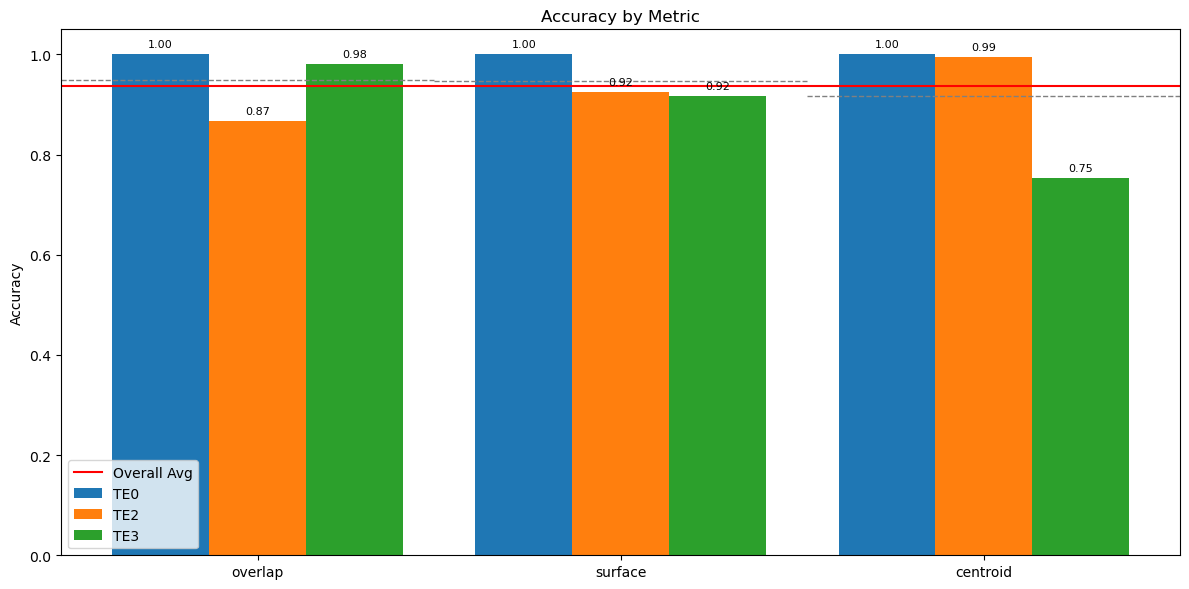

In [174]:
# Plot mesh results by area or metric
def plot_mesh_results(results_dict, group_by='area'):
    """
    Plot results_dict as a grouped barplot.
    
    Parameters:
    - results_dict: dict of {metric: {area: accuracy}}
    - group_by: either 'area' or 'metric'
    """
    metrics = list(results_dict.keys())
    areas = list(next(iter(results_dict.values())).keys())

    fig, ax = plt.subplots(figsize=(12, 6))

    if group_by == 'area':
        labels = areas
        group_keys = metrics
        bar_data = {metric: [results_dict[metric][area] for area in areas] for metric in metrics}
    elif group_by == 'metric':
        labels = metrics
        group_keys = areas
        bar_data = {area: [results_dict[metric][area] for metric in metrics] for area in areas}
    else:
        raise ValueError("group_by must be 'area' or 'metric'")

    x = np.arange(len(labels))
    width = 0.8 / len(group_keys)  # Total bar width will be < 1

    # Plot each group
    for i, key in enumerate(group_keys):
        offsets = x - 0.4 + i * width + width / 2
        y = bar_data[key]
        bars = ax.bar(offsets, y, width, label=key)

        # Add height labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.2f}',
                    ha='center', va='bottom', fontsize=8)

    # Add per-group average lines
    for i, xi in enumerate(x):
        if group_by == 'area':
            group_vals = [results_dict[metric][labels[i]] for metric in metrics]
        else:
            group_vals = [results_dict[labels[i]][area] for area in areas]
        group_avg = np.mean(group_vals)
        ax.axhline(group_avg, color='gray', linestyle='--', linewidth=1, xmin=xi/len(x), xmax=(xi+1)/len(x))

    # Add overall average line
    all_vals = [v for metric in results_dict.values() for v in metric.values()]
    overall_avg = np.mean(all_vals)
    ax.axhline(overall_avg, color='red', linestyle='-', linewidth=1.5, label='Overall Avg')

    ax.set_ylabel('Accuracy')
    ax.set_title(f'Accuracy by {"Area" if group_by=="area" else "Metric"}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(0, 1.05)
    ax.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_mesh_results(metric_to_area_to_accuracy, group_by='metric')

In [175]:
# (NOT FUNCTIONAL) Plot planes of separation
def plot_multiple_separators(label_to_points, label_pairs, point_size=5, 
                             title='Nonlinear Separators', axes=['X', 'Y', 'Z'],
                             colors=['red', 'blue', 'green', 'black', 'white', 'aqua', 'yellow']):
    fig = go.Figure()

    # Add point clouds
    for i, (label, points) in enumerate(label_to_points.items()):
        pts = points.T
        fig.add_trace(go.Scatter3d(x=pts[:,0], y=pts[:,1], z=pts[:,2],
                           mode='markers', name=str(label),
                           marker=dict(size=point_size, color=colors[i])))
    
    colors = ['Viridis', 'Blues', 'Reds', 'Greens', 'Oranges', 'Cividis']
    
    # Plot each separating surface
    for i, (label_a, label_b) in enumerate(label_pairs):
        A = label_to_points[label_a].T
        B = label_to_points[label_b].T
        X = np.vstack([A, B])
        y = np.array([0]*len(A) + [1]*len(B))
        
        clf = SVC(kernel='rbf', gamma='scale')
        clf.fit(X, y)

        mins, maxs = X.min(0) - 1, X.max(0) + 1
        grid_x, grid_y, grid_z = [np.linspace(m, M, 25) for m, M in zip(mins, maxs)]
        xx, yy, zz = np.meshgrid(grid_x, grid_y, grid_z)
        grid = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
        decision = clf.decision_function(grid).reshape(xx.shape)

        fig.add_trace(go.Isosurface(
            x=xx.ravel(), y=yy.ravel(), z=zz.ravel(), value=decision.ravel(),
            isomin=0, isomax=0, surface_count=1, opacity=0.6,
            showscale=False, caps=dict(x_show=False, y_show=False, z_show=False),
            name=f'{label_a} vs {label_b}', colorscale=colors[i]
        ))

    fig.update_layout(scene=dict(xaxis_title=axes[0], yaxis_title=axes[1], zaxis_title=axes[2]),
                      title=title)
    
    return fig

fig = plot_multiple_separators(area_to_coords, [('IT', 'HC'), ('HC', 'MT')], point_size=3, 
                               title='Area separation w/ RBF SVC', axes=['ML', 'AP', 'DV'],
                               colors=colors)

fig.write_html(os.path.join(locker_path, 'users/Parsa/area_sep.html'))

fig.show()

KeyError: 'IT'

In [176]:
unique_combinations = sorted(sess_coords['monkey_area'].unique())
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_combinations)))
color_map = dict(zip(unique_combinations, colors))

In [ ]:
# Plot coordinate ranges, centers
if graph_labels:
    '''
    Plot coordinate ranges, centers
    '''
    df = sess_coords
    
    # Create subplots for each axis
    fig, axes = plt.subplots(3, 1, figsize=(8, 18))
    axes = axes.flatten()
    axis_names = ['ml', 'dv', 'ap']
    
    for ax_idx, axis_name in enumerate(axis_names):
        df.sort_values(by=f'{axis_name}_start', inplace=True)
        ax = axes[ax_idx]
        
        y_pos = 0
        y_labels = []
        y_positions = []
        
        for combo in unique_combinations:
            combo_data = df[df['monkey_area'] == combo]
            color = color_map[combo]
            
            # Calculate averages
            avg_start = combo_data[f'{axis_name}_start'].mean()
            avg_end = combo_data[f'{axis_name}_end'].mean()
            
            for idx, row in combo_data.iterrows():
                start_val = row[f'{axis_name}_start']
                end_val = row[f'{axis_name}_end']
                
                ax.scatter(start_val, y_pos, color=color, s=80, marker='o', alpha=0.7)
                ax.scatter(end_val, y_pos, color=color, s=80, marker='s', alpha=0.7)
                ax.plot([start_val, end_val], [y_pos, y_pos], 
                        color=color, linewidth=1, alpha=0.5)
                y_pos += 1
            
            # Add average range line
            combo_center = y_pos - len(combo_data)/2 - 0.5
            ax.plot([avg_start, avg_end], [combo_center, combo_center], 
                    color=color, linewidth=4, alpha=0.8, zorder=10)
            ax.scatter([avg_start, avg_end], [combo_center, combo_center], 
                      color=color, s=120, marker='D', zorder=10, edgecolor='black', linewidth=1)
        
            y_labels.append(combo)
            y_positions.append(combo_center)
        
        ax.set_xlabel(f'{axis_name.upper()} Value (mm)')
        ax.set_title(f'{axis_name.upper()} Ranges for Labeled Channels\n{len(df.date.unique())} sessions')
        ax.grid(True, alpha=0.3)
        ax.set_ylabel('Monkey-Area Combination')
        ax.set_yticks(y_positions)
        ax.set_yticklabels(y_labels)
        
    # Add legend to the last subplot
    start_handle = plt.Line2D([0], [0], marker='o', color='gray', linestyle='', markersize=8, label='Start')
    end_handle = plt.Line2D([0], [0], marker='s', color='gray', linestyle='', markersize=8, label='End')
    avg_handle = plt.Line2D([0], [0], marker='D', color='gray', linestyle='', markersize=10, label='Average Range')
    axes[-1].legend(handles=[start_handle, end_handle, avg_handle], loc='upper right')
    
    plt.tight_layout()
    
    plt.savefig('/mnt/smb/locker/issa-locker/users/Parsa/marmoset_figures/labeled_coordinate_ranges/coordinate_ranges.png')
    
    plt.show()
    
    # Create the 2D scatter plot
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot for each row
    for idx, row in df.iterrows():
        monkey_area = row['monkey_area']
        color = color_map[monkey_area]
        
        # Plot start and end points
        ax.scatter(row['ml_start'], row['ap_start'], color=color, s=100, marker='o', alpha=0.8, label=monkey_area if idx == 0 or monkey_area not in [df.iloc[i]['monkey_area'] for i in range(idx)] else "")
        ax.scatter(row['ml_end'], row['ap_end'], color=color, s=100, marker='s', alpha=0.8)
        
        # Connect start and end points with a line
        ax.plot([row['ml_start'], row['ml_end']], [row['ap_start'], row['ap_end']], 
                color=color, linewidth=2, alpha=0.7)
    
    ax.set_xlabel('ML Value')
    ax.set_ylabel('AP Value')
    ax.set_title('AP vs ML: Start/End Positions by Monkey-Area')
    ax.grid(True, alpha=0.3)
    
    # Create legend with unique combinations and marker types
    handles = []
    labels = []
    
    # Add monkey-area combinations
    for combo in unique_combinations:
        handles.append(plt.Line2D([0], [0], color=color_map[combo], linewidth=3, label=combo))
        labels.append(combo)
    
    # Add separator and marker explanations
    handles.append(plt.Line2D([0], [0], color='white', linewidth=0))  # spacer
    labels.append('')
    handles.append(plt.Line2D([0], [0], marker='o', color='gray', linestyle='', markersize=10, label='Start Position'))
    labels.append('Start Position')
    handles.append(plt.Line2D([0], [0], marker='s', color='gray', linestyle='', markersize=10, label='End Position'))
    labels.append('End Position')
    
    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    
    plt.savefig('/mnt/smb/locker/issa-locker/users/Parsa/marmoset_figures/labeled_coordinate_ranges/ap_vs_ml_ranges.png')
    
    plt.show()

In [56]:
### RESUME HERE IF SKIPPED

In [57]:
# Finalize labeled channels dataframe by adding dates + ch_idx_glx and removing nans.

# Add dates
labeled_ch_df = labeled_ch_df.merge(all_recording_data[['monkey', 'hole', 'pen_id', 'date']],
                                    on=['monkey', 'hole', 'pen_id'], how='inner')

# Merge with site coords to add ch_idx_glx data
labeled_ch_df = labeled_ch_df.merge(site_coords, on=['date', 'ch_idx_depth'], how='left')

# Remove nans
labeled_ch_df = labeled_ch_df[-labeled_ch_df['ch_idx_glx'].isna()]
labeled_ch_df['ch_idx_glx'] = labeled_ch_df['ch_idx_glx'].astype('int')

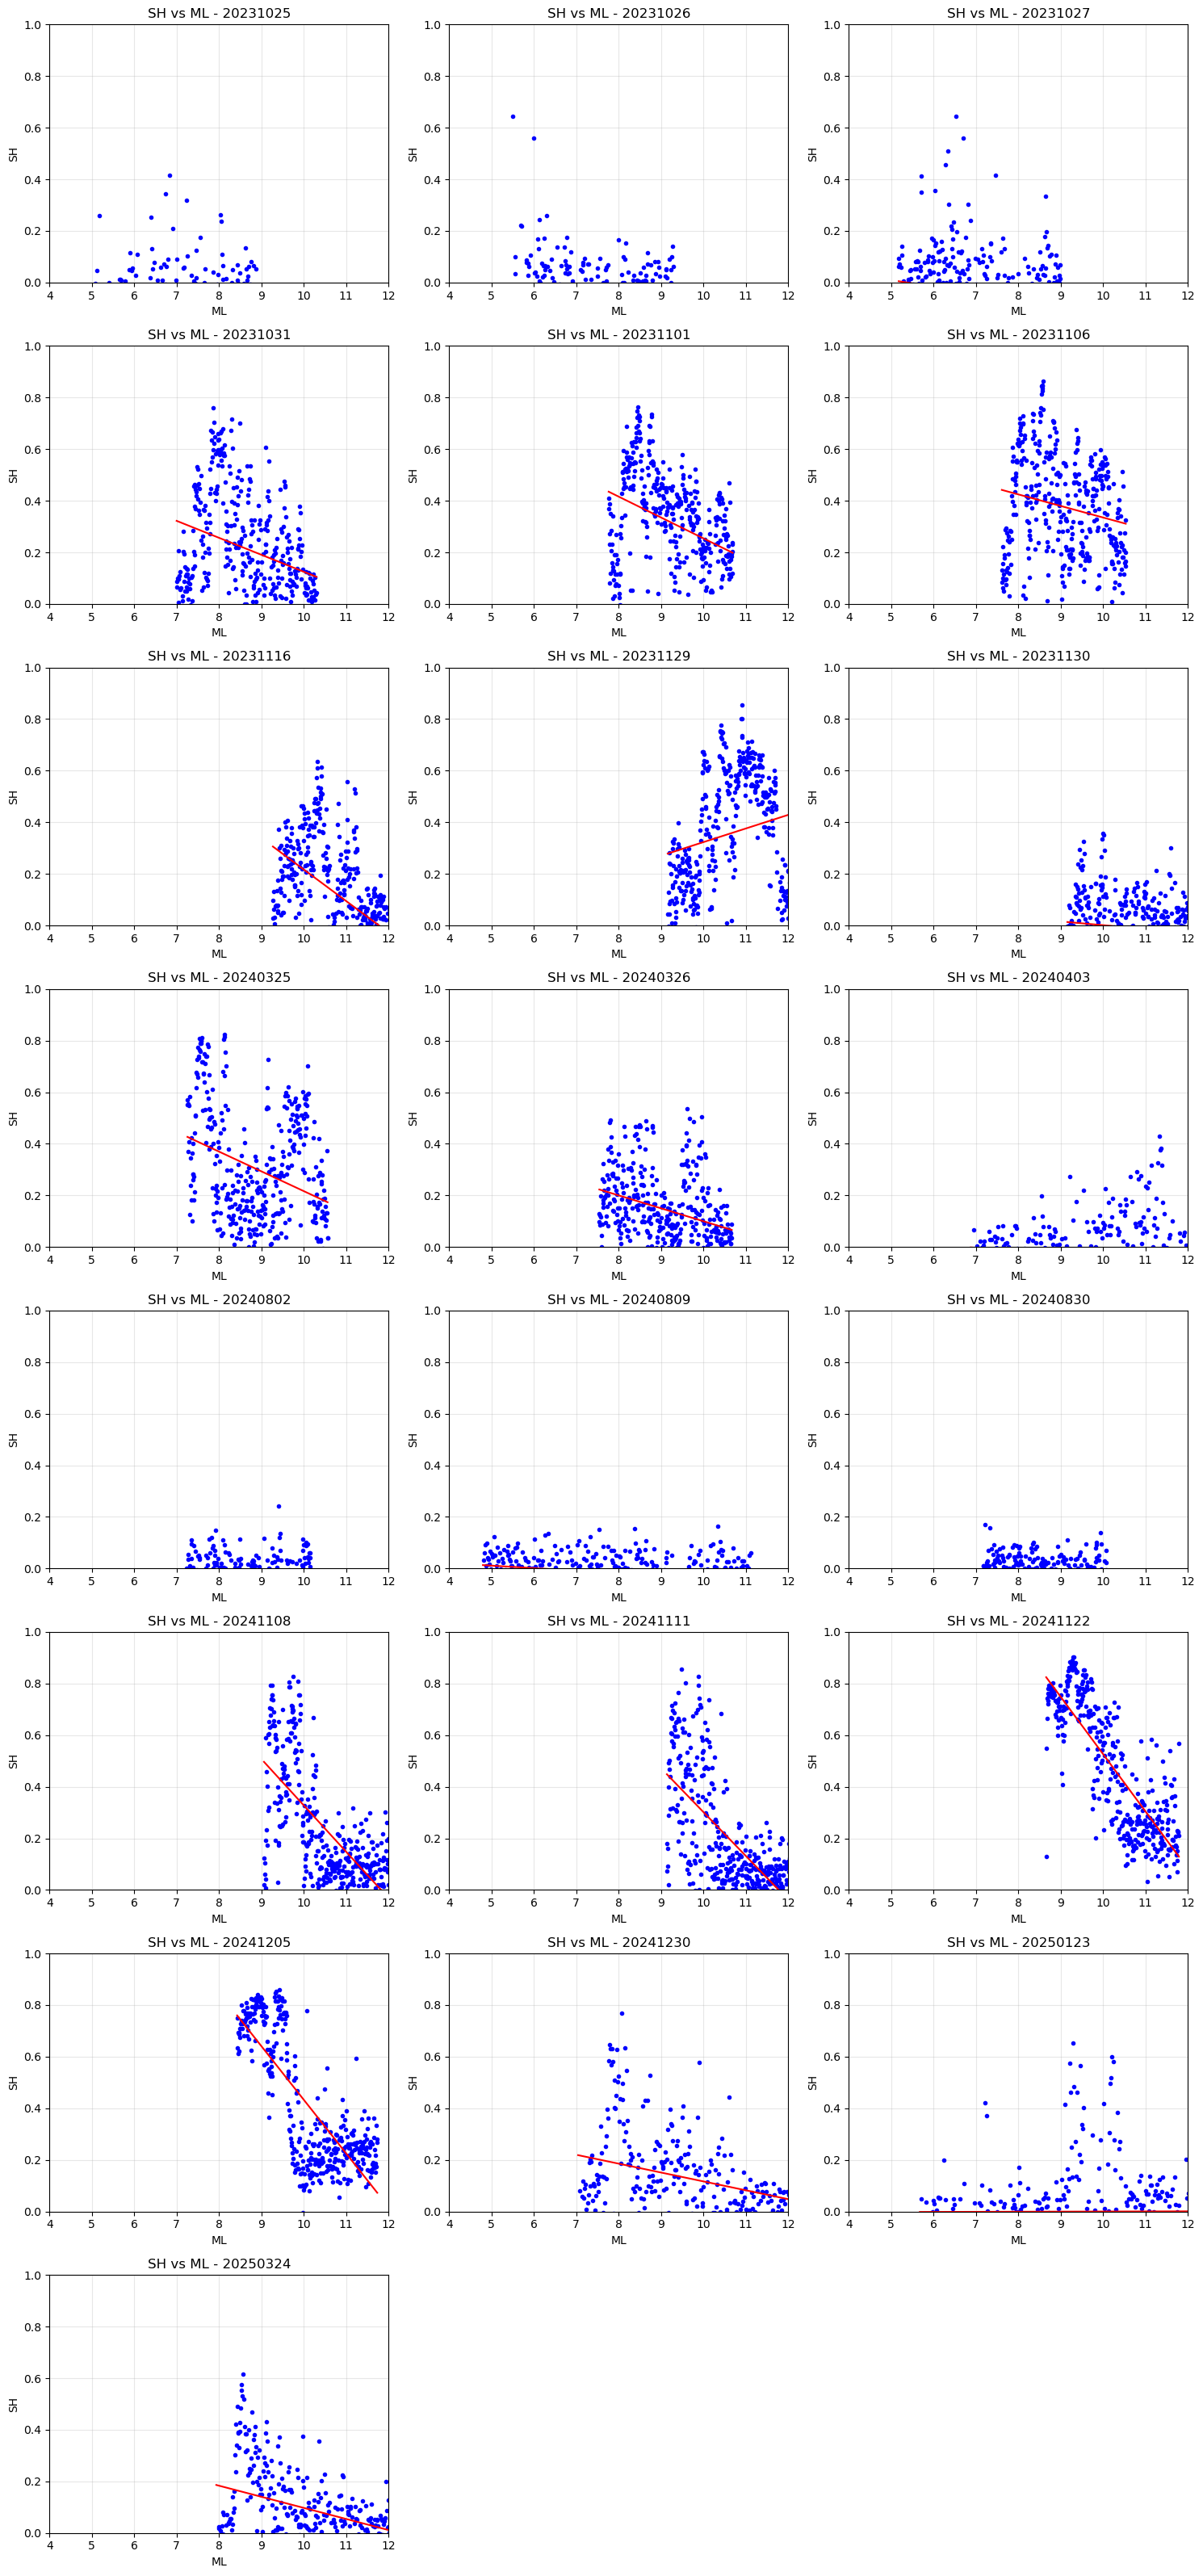

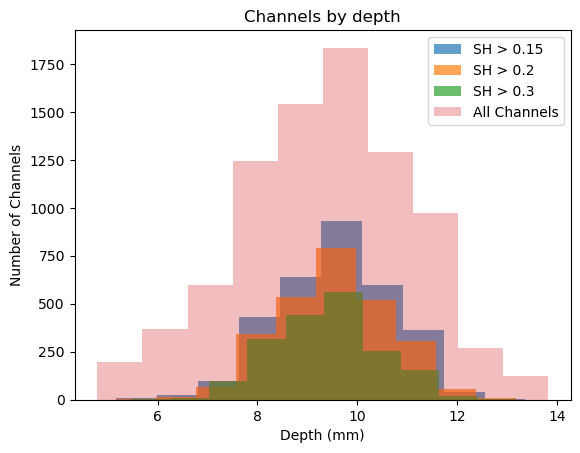

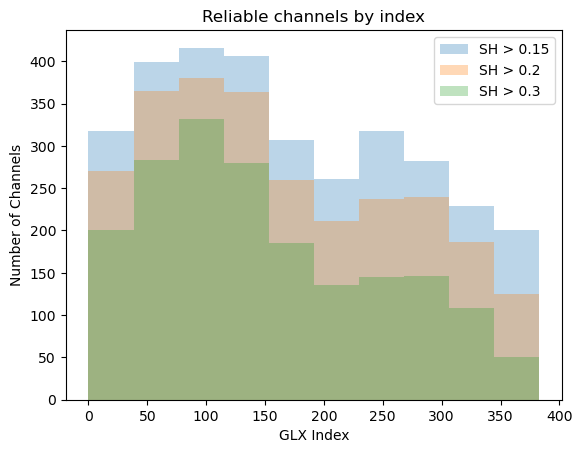

In [58]:
# Plot sh vs depth, reliable depths
date_to_depth = {}
for date in dates:
    df = site_coords[site_coords['date']==date].copy().sort_values(by='ch_idx_glx')
    assert df.shape[0]==384
    date_to_depth[date] = np.array(df['ml'].values)

def plot_sh_vs_depth(date_to_sh, date_to_depth):
    """
    Create separate plots for each date showing sh as a function of depth
    """
    # Get all dates (assuming both dictionaries have the same keys)
    dates = sorted(list(date_to_sh.keys()))
    
    # Create subplots - adjust the layout based on number of dates
    n_dates = len(dates)
    cols = min(3, n_dates)  # Max 3 columns
    rows = (n_dates + cols - 1) // cols  # Calculate rows needed
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    
    # Handle case where there's only one subplot
    if n_dates == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if n_dates > 1 else [axes]
    else:
        axes = axes.flatten()
    
    # Plot each date
    for i, date in enumerate(dates):
        ax = axes[i]
        sh_values = date_to_sh[date]
        depth_values = date_to_depth[date]
        ax.set_xlim(4, 12)
        ax.set_ylim(0, 1)
        ax.plot(depth_values, sh_values, 'bo', markersize=3)
        ax.plot(np.unique(depth_values), np.poly1d(np.polyfit(depth_values, sh_values, 1))(np.unique(depth_values)), c='r')
        ax.set_xlabel('ML')
        ax.set_ylabel('SH')
        ax.set_title(f'SH vs ML - {date}')
        ax.grid(True, alpha=0.3)
    
    # Hide any unused subplots
    for i in range(n_dates, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()

plot_sh_vs_depth(date_to_sh, date_to_depth)
plt.savefig(os.path.join(plot_dir_path, 'sh_vs_depth.png'))
plt.show()

date_to_reliable_depths = {}
for limit in sh_limits:
    date_dict = {}
    date_dict = sh_limit_to_date_to_ch[limit]
    for date, depths in date_to_depth.items():
        date_to_reliable_depths[date] = depths[date_dict[date]]
    reliable_depths = list(np.concatenate(list(date_to_reliable_depths.values())))
    plt.hist(reliable_depths, alpha=.7, label=f'SH > {limit}')
depths = list(np.concatenate(list(date_to_depth.values())))
plt.hist(depths, alpha=.3, label='All Channels')
plt.legend()
plt.title(f'Channels by depth')
plt.xlabel('Depth (mm)')
plt.ylabel(f'Number of Channels')
plt.savefig(os.path.join(plot_dir_path, 'ch_vs_depth.png'))
plt.show()

for limit in sh_limits:
    date_dict = {}
    date_dict = sh_limit_to_date_to_ch[limit]
    ch_idx = list(np.concatenate(list(date_dict.values())))
    plt.hist(ch_idx, alpha=0.3, label = f'SH > {limit}')
plt.title(f'Reliable channels by index')
plt.xlabel('GLX Index')
plt.legend()
plt.ylabel(f'Number of Channels')
plt.savefig(os.path.join(plot_dir_path, 'ch_vs_glx.png'))
plt.show()

In [59]:
# Create cutoff dataframe
cutoff_df = pd.DataFrame(list(itertools.product(cutoffs, ['IT', 'MT'])), columns=[
    'depth_cutoff',
    'area'
])

cutoff_df = pd.concat((cutoff_df, pd.DataFrame(columns=['channels_used',
                                                        'RDM_shr',
                                                        'RDM_error',
                                                        'date_to_ch',
                                                        'trial_avg_series',
                                                        'ch_shr',
                                                        'single_RDM_shr',
                                                        'ch_RDM_shr',
                                                        'ch_RDM_error'], dtype='object')))

In [60]:
# Functions for df --> trial averaged responses --> rdm --> rdm-rdm correlation

# need to rename this
def trial_avg_matrix(df, date_to_sh=None, date_to_ch=None, unusable_dates=[]):
    '''
    Returns 2 dfs with unique images as rows, unique channel*date as column
    date_to_ch: filters channels by date
    '''
    if unusable_dates:
        rdm_filt_df = df[~df['date'].isin(unusable_dates)][['date','img_full_path', 'psth']]
    else:
        rdm_filt_df = df[['date','img_full_path', 'psth']]
    
    # Create empty df of img x date
    unique_img = rdm_filt_df['img_full_path'].unique()
    unique_date = rdm_filt_df['date'].unique()
    img_date_df = pd.DataFrame(index=unique_img, columns=unique_date)
    img_date_df_half2 = pd.DataFrame(index=unique_img, columns=unique_date)
    
    # Create list for storing split-halves values corresponding to channel index
    sh_dict = {}
    
    # List of dates to drop bc empty
    drop_dates = []
    
    # Average across bins, repeats for each image x date combination
    img_date_grouped = rdm_filt_df.groupby(['img_full_path', 'date'])
    
    for (img, date), group in img_date_grouped:
        # Create repeats x ch x bins matrix
        psth_tot = np.stack(group['psth'].values) 
        # Filter channels
        if date_to_ch:
            # Check if date has any usable channels...
            if date in date_to_ch.keys():
                psth_tot = psth_tot[:, date_to_ch[date], :]
                # Store split-halves data for channels if necessary...
                if date_to_sh and not date in sh_dict:
                    sh_dict[date] = date_to_sh[date][date_to_ch[date]] # These channel orders should align...
            elif date not in drop_dates:
                drop_dates.append(date)
                continue
        
        # Average across bins
        spikes = psth_tot.mean(axis=2)
        
        # Shuffle, split trials
        np.random.shuffle(spikes)
        spikes_half1, spikes_half2 = np.array_split(spikes, 2, axis=0)
        
        # Assign halves
        img_date_df.loc[img, date] = spikes_half1.mean(axis=0)
        img_date_df_half2.loc[img, date] = spikes_half2.mean(axis=0)
    
    if drop_dates:
        drop_dates_str = ', '.join(drop_dates)
        print(f'{drop_dates_str} not in date_to_ch, will be dropped')
        img_date_df.drop(columns=drop_dates, inplace=True)
        img_date_df_half2.drop(columns=drop_dates, inplace=True)
        
    if len(sh_dict) > 0:
        sh_arr = np.hstack(list(sh_dict.values())) # !!! IMPORTANT: Relies on ordered dictioary keys, Python 3.7+
    else:
        sh_arr = None
    
    # Stack date (column) vectors for neural data and split halves
    img_series = img_date_df.apply(lambda row: np.hstack(row.values), axis=1)
    img_series_2 = img_date_df_half2.apply(lambda row: np.hstack(row.values), axis=1)
    
    return img_series, img_series_2, sh_arr, drop_dates

def rdm(data):
    # Calculate and plot RDM from img x ch/date matrix
    norm_data = zscore(data, axis=1)
    return squareform(pdist(norm_data, metric='correlation'))

def correlate_rdms(rdm1, rdm2):
    # Extract off-diagonal elements of each RDM
    ioffdiag = np.triu_indices(rdm1.shape[0], k=1)  # indices of off-diagonal elements
    rdm1_offdiag = rdm1[ioffdiag]
    rdm2_offdiag = rdm2[ioffdiag]
  
    corr_coef = np.corrcoef(rdm1_offdiag, rdm2_offdiag)[0,1]
  
    return corr_coef

In [61]:
# Function for converting and combining labeled dictionaries <--> dataframes
def ch_df_from_dict(ch_dict):
    df = pd.DataFrame(list(ch_dict.items()), columns=['date', 'ch_idx_glx'])
    return df.explode('ch_idx_glx').reset_index(drop=True)

def ch_overlap_dict(ch_dict, ch_df):
    inner_df = pd.merge(ch_df, ch_df_from_dict(ch_dict), on=['date', 'ch_idx_glx'], how='inner')
    df_to_int = lambda x: x.astype('int64').values
    inner_dict = inner_df.groupby('date')['ch_idx_glx'].apply(df_to_int).to_dict()
    return inner_dict

In [49]:
# Loop through all area/cutoff combinations and gather data
start = time.time()
for area, west_cutoff in itertools.product(areas, cutoffs):
    print(f'\nChecking {area} cut off at {west_cutoff}...')
    
    # Set mask
    cutoff_area_mask = (cutoff_df['depth_cutoff']==west_cutoff) & (cutoff_df['area']==area)
    # Need row index to use .at when storing dict/series
    row_idx = cutoff_area_mask[cutoff_area_mask].index[0]
    
    # Generate cutoffs
    # Note: -diff on IT b/c > cutoff, +diff on MT b/c < cutoff (account for bour smaller head)
    if area == 'IT':
        bour_mask = (site_coords['monkey']=='Bourgeois') & (site_coords['ml']>west_cutoff - west_bour_diff)
        west_mask = (site_coords['monkey']=='West') & (site_coords['ml']>(west_cutoff))
    elif area == 'MT':
        bour_mask = (site_coords['monkey']=='Bourgeois') & (site_coords['ml']<west_cutoff + west_bour_diff)
        west_mask = (site_coords['monkey']=='West') & (site_coords['ml']<(west_cutoff))
    
    # Create IT specific and MT specific dataframes
    area_df = site_coords[bour_mask|west_mask]
    
    # Determine dates to cross reference ashley labels with:
    labeled_dates_used = [date for date in final_df.date.unique() if date in labeled_dates]
    
    # Check IT ranges
    for date in labeled_dates_used:
        area_ch = area_df[area_df.date==date].ch_idx_glx.unique()
        if len(area_ch) > 0:
            print(f'{date} {area} channels: {min(area_ch)} to {max(area_ch)}')
        else:
            print(f'{date} {area} has no channels')
    
    # Get date to reliable channel dictionary, store it
    area_date_to_reliable_ch = ch_overlap_dict(date_to_reliable_ch, area_df)
    for monkey in monkeys:
        ch_count = sum(len(ch_arr) for date, ch_arr in area_date_to_reliable_ch.items() if date in monkey_to_dates[monkey])
        print(f'{monkey} {area} ch: {ch_count}')
    total_ch_count = sum(len(ch_arr) for ch_arr in area_date_to_reliable_ch.values())
    cutoff_df.loc[cutoff_area_mask, 'channels_used'] = total_ch_count
    print(f'Total {area} ch: {total_ch_count}')
    date_to_ch = area_date_to_reliable_ch
        
    # Wrap in list to store
    cutoff_df.at[row_idx, 'date_to_ch'] = date_to_ch
    
    # Get trial averaged values, single RDM SHR
    trial_avg_series, trial_avg_half2, sh_arr, unusable_dates = trial_avg_matrix(final_df,
                                                                                 date_to_ch=date_to_ch,
                                                                                 date_to_sh=date_to_sh)
    
    rdm_half1 = rdm(np.vstack(trial_avg_series.values))
    rdm_half2 = rdm(np.vstack(trial_avg_half2.values))
    rdm_shr = correlate_rdms(rdm_half1, rdm_half2)
    
    # Wrap trial_avg_series in list to store
    cutoff_df.at[row_idx, 'trial_avg_series'] = trial_avg_series
    cutoff_df.loc[cutoff_area_mask, 'single_RDM_shr'] = rdm_shr
    cutoff_df.at[row_idx, 'ch_shr'] = sh_arr
    
    # Get RDM SHR, error
    rdm_shrs = np.zeros(rdm_shr_folds)
    for fold in range(rdm_shr_folds):
        half1, half2, _, _ = trial_avg_matrix(final_df, date_to_ch=date_to_ch, unusable_dates=unusable_dates)
        rdm_half1 = rdm(np.vstack(half1.values))
        rdm_half2 = rdm(np.vstack(half2.values))
        rdm_shrs[fold] = correlate_rdms(rdm_half1, rdm_half2)
        print(f'Done with fold {fold+1}...')
    rdm_shr_err = np.std(rdm_shrs)
    rdm_avg_shr = np.mean(rdm_shrs)
    cutoff_df.loc[cutoff_area_mask, 'RDM_error'] = np.std(rdm_shrs)
    cutoff_df.loc[cutoff_area_mask, 'RDM_shr'] = np.mean(rdm_shrs)

    # Note: only using the main half-trial averaged data
    neural = np.vstack(trial_avg_series.values)
    
    ch_count_to_RDM_shr = {}
    ch_count_to_RDM_error = {}
    
    for ch_count in ch_samples:
        if ch_count > int(total_ch_count/2):
            print(f'{area} {west_cutoff} has < {ch_count*2} total channels, cannot split.')
            break
        ch_rdm_shrs = np.zeros(ch_rdm_shr_folds)
        for fold in range(ch_rdm_shr_folds):
            # Sample without replacement from all indices enough for 2*ch_count
            random_ch_idx = np.random.choice(total_ch_count, size=2*ch_count, replace=False)
            half1_ch_idx = random_ch_idx[:ch_count]
            half2_ch_idx = random_ch_idx[ch_count:]
            # Calculate RDM corr
            rdm_half1 = rdm(neural[:, half1_ch_idx])
            rdm_half2 = rdm(neural[:, half2_ch_idx])
            ch_rdm_shrs[fold] = correlate_rdms(rdm_half1, rdm_half2)
        # Assign RDM SHR + Error for chosen sample size
        ch_count_to_RDM_error[ch_count] = np.std(ch_rdm_shrs)
        ch_count_to_RDM_shr[ch_count] = np.mean(ch_rdm_shrs)
    # Store channel-sampled RDM SHR + error for given cutoff
    cutoff_df.at[row_idx, 'ch_RDM_error'] = ch_count_to_RDM_error
    cutoff_df.at[row_idx, 'ch_RDM_shr'] = ch_count_to_RDM_shr

    print(f'Done with {area}, {west_cutoff}.')

end = time.time()
runtime = end-start
process = 'Full Area RDM SHR'
process_to_runtime[process] = runtime
print(f'Runtime: {runtime:.4f}s')


Checking IT cut off at 8...


NameError: name 'labeled_dates' is not defined

In [ ]:
###### Plot cutoff - RDM SHR/channels ######
title = f'{imageset}\n{dec_column} decoding: {avg_dec_score:.2f}, {len(dates)} sessions\n Channel SH > {sh_limit}'

# Create figure with 2 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

# First subplot - Channels Used vs Depth Cutoff
for area in cutoff_df['area'].unique():
    df = cutoff_df[cutoff_df['area']==area]
    df = df[['depth_cutoff', 'channels_used']].astype('float')
    ax1.errorbar(df['depth_cutoff'], df['channels_used'], label=area)

# Infer ticks based on range, set title + labels
step = np.diff(cutoffs).min()
ax1.set_xticks(np.arange(min(cutoffs), max(cutoffs)+step, step))
ax1.set_xlabel('Depth Cutoff')
ax1.set_ylabel('Channels Used')
ax1.set_title('Channels Used vs Depth Cutoff')
ax1.legend()
ax1.grid(True, alpha=0.3)

###### Plot cutoff - RDM Corrs ######
it_data = None
mt_data = None

for area in cutoff_df['area'].unique():
    df = cutoff_df[cutoff_df['area']==area]
    df = df[['depth_cutoff', 'RDM_shr', 'RDM_error', 'channels_used']].astype('float')
    
    # Store IT and MT data for sum calculation
    if area == 'IT':
        it_data = df.copy()
    elif area == 'MT':
        mt_data = df.copy()
    
    # Plot line with error bars
    ax2.errorbar(df['depth_cutoff'], df['RDM_shr'], label=area)
    
    # Add error band
    ax2.fill_between(df['depth_cutoff'], 
                     df['RDM_shr'] - df['RDM_error'], 
                     df['RDM_shr'] + df['RDM_error'], 
                     alpha=0.3)

# Add IT + MT sum line
if it_data is not None and mt_data is not None and plot_sum is True:
    # Merge on depth_cutoff to align data points
    merged = it_data.merge(mt_data, on='depth_cutoff', suffixes=('_it', '_mt'))
    
    # Calculate sum of RDM_shr and RDM_error
    sum_shr = merged['RDM_shr_it'] + merged['RDM_shr_mt']
    sum_error = merged['RDM_error_it'] + merged['RDM_error_mt']
    
    # Plot sum line
    ax2.errorbar(merged['depth_cutoff'], sum_shr, label='IT + MT')
    
    # Add error band for sum
    ax2.fill_between(merged['depth_cutoff'], 
                     sum_shr - sum_error, 
                     sum_shr + sum_error, 
                     alpha=0.3)

step = np.diff(cutoffs).min()
ax2.set_xticks(np.arange(min(cutoffs), max(cutoffs)+step, step))
ax2.set_xlabel('Depth Cutoff')
ax2.set_ylabel('RDM SHR')
ax2.set_title('RDM SHR vs Depth Cutoff')
ax2.legend()
ax2.grid(True, alpha=0.3)

###### Plot cutoff - channel-wise RDM Corrs ######
it_data = None
mt_data = None

for area in cutoff_df['area'].unique():
    df = cutoff_df[cutoff_df['area']==area]
    df = df[['depth_cutoff', 'ch_RDM_shr', 'ch_RDM_error', 'channels_used']] # removed astype(float)
    
    # Store IT and MT data for sum calculation
    if area == 'IT':
        it_data = df.copy()
        ax = ax3
    elif area == 'MT':
        mt_data = df.copy()
        ax = ax4
    
    for ch_count in ch_samples:
        # Get RDM shr + error for given count as a series
        ch_RDM_shr_series = df['ch_RDM_shr'].apply(lambda count_dict: count_dict.get(ch_count, np.nan))
        ch_RDM_error_series = df['ch_RDM_error'].apply(lambda count_dict: count_dict.get(ch_count, np.nan))
        # Plot line with error bars
        ax.errorbar(df['depth_cutoff'], ch_RDM_shr_series, label=f'{ch_count}ch')
        
        # Add error band
        ax.fill_between(df['depth_cutoff'], 
                         ch_RDM_shr_series - ch_RDM_error_series, 
                         ch_RDM_shr_series + ch_RDM_error_series, 
                         alpha=0.3)

    step = np.diff(cutoffs).min()
    ax.set_xticks(np.arange(min(cutoffs), max(cutoffs)+step, step))
    ax.set_xlabel('Depth Cutoff')
    ax.set_ylabel('RDM SHR')
    ax.set_title(f'Channel-Sampled RDM SHR\n{area}')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Add main title above both subplots
fig.suptitle(title, fontsize=13, y=.98)

# Adjust layout and display
plt.tight_layout()

plt.savefig(os.path.join(plot_dir_path, 'cutoff_plot.png'))

plt.show()

In [48]:
# Add no cutoff/both areas data ('All', uses all reliable channels)
if not (cutoff_df['area']=='All').any():
    cutoff_df = pd.concat([cutoff_df, pd.DataFrame({'area': ['All']})], ignore_index=True)

# Set mask
cutoff_area_mask = cutoff_df['area']=='All'
# Need row index to use .at when storing dict/series
row_idx = cutoff_area_mask[cutoff_area_mask].index[0]

# Get trial averaged values, single RDM SHR
date_to_ch = date_to_reliable_ch
total_ch_count = sum(len(ch_arr) for ch_arr in date_to_reliable_ch.values())
cutoff_df.loc[cutoff_area_mask, 'channels_used'] = total_ch_count
cutoff_df.at[row_idx, 'date_to_ch'] = date_to_ch

trial_avg_series, trial_avg_half2, sh_arr, unusable_dates = trial_avg_matrix(final_df, 
                                                                             date_to_sh=date_to_sh,
                                                                             date_to_ch=date_to_ch)

rdm_half1 = rdm(np.vstack(trial_avg_series.values))
rdm_half2 = rdm(np.vstack(trial_avg_half2.values))
rdm_shr = correlate_rdms(rdm_half1, rdm_half2)

# Wrap trial_avg_series in list to store
cutoff_df.at[row_idx, 'trial_avg_series'] = trial_avg_series
cutoff_df.loc[cutoff_area_mask, 'single_RDM_shr'] = rdm_shr
cutoff_df.at[row_idx, 'ch_shr'] = sh_arr

# Get RDM SHR, error
start = time.time()
rdm_shrs = np.zeros(rdm_shr_folds)
for fold in range(rdm_shr_folds):
    half1, half2, _, _ = trial_avg_matrix(final_df, 
                                          date_to_ch=date_to_ch,
                                          date_to_sh=date_to_sh,
                                          unusable_dates=unusable_dates)
    rdm_half1 = rdm(np.vstack(half1.values))
    rdm_half2 = rdm(np.vstack(half2.values))
    rdm_shrs[fold] = correlate_rdms(rdm_half1, rdm_half2)
    print(f'Done with fold {fold+1}...')
rdm_shr_err = np.std(rdm_shrs)
rdm_avg_shr = np.mean(rdm_shrs)

cutoff_df.loc[cutoff_area_mask, 'RDM_error'] = np.std(rdm_shrs)
cutoff_df.loc[cutoff_area_mask, 'RDM_shr'] = np.mean(rdm_shrs)
print(f'Done with all ch.')

end = time.time()
runtime = end-start
process = 'RDM SHR'
process_to_runtime[process] = runtime
print(f'Runtime: {runtime:.4f}s')

Done with fold 1...
Done with fold 2...
Done with fold 3...
Done with fold 4...
Done with fold 5...
Done with all ch.
Runtime: 11.1106s


In [63]:
for area in areas:
    print(f'{area} labeled ch count: {len(ch_coords[(ch_coords.area==area)&(ch_coords.date.isin(dates))])}')

IT labeled ch count: 4572
TE0 labeled ch count: 1750
TE2 labeled ch count: 808
TE3 labeled ch count: 1230


In [64]:
# Add in Ashley labeled column here (cutoff=='labeled'), and interpolated values (cutoff=='predicted')

# Get date to reliable channel dictionary, store it
for area, cutoff in itertools.product(areas, ['labeled']): # ['labeled', 'predicted']
    print(f'Starting {cutoff}:')
    # Create new row if doesn't exist
    if not ((cutoff_df['depth_cutoff']==cutoff)&(cutoff_df['area']==area)).any():
        cutoff_df = pd.concat([cutoff_df, pd.DataFrame({'depth_cutoff': [cutoff],
                                                   'area': [area]})], ignore_index=True)
    
    # Set mask
    cutoff_area_mask = (cutoff_df['area']==area) & (cutoff_df['depth_cutoff']==cutoff)
    # Need row index to use .at when storing dict/series
    row_idx = cutoff_area_mask[cutoff_area_mask].index[0]
    
    # Get reliable channel dictionary based on cutoff
    if cutoff=='predicted':
        # start_spline: AP coord --> start of IT
        for monkey in monkeys:
            start_spline = monkey_to_start_spline[monkey]
            monkey_mask = site_coords['monkey']==monkey
            site_coords.loc[monkey_mask, 'start_IT'] = start_spline(site_coords.loc[monkey_mask, 'ap'])
        if area == 'IT':
            bour_mask = ((site_coords['monkey']=='Bourgeois') &
                         (site_coords['ml'] > (site_coords['start_IT']))) # - west_bour_diff
            west_mask = ((site_coords['monkey']=='West') & 
                         (site_coords['ml']>site_coords['start_IT']))
        elif area == 'MT':
            bour_mask = ((site_coords['monkey']=='Bourgeois') & 
                         (site_coords['ml'] < site_coords['start_IT'])) # + west_bour_diff
            west_mask = ((site_coords['monkey']=='West') & 
                         (site_coords['ml']<site_coords['start_IT']))
        area_df = site_coords[bour_mask|west_mask]
        area_date_to_reliable_ch = ch_overlap_dict(date_to_reliable_ch, area_df)
    elif cutoff=='labeled':
        area_date_to_reliable_ch = ch_overlap_dict(date_to_reliable_ch, 
                                               labeled_ch_df[labeled_ch_df['area']==area])
    
    # Check channel counts
    for monkey in monkeys:
        ch_count = sum(len(ch_arr) for date, ch_arr in area_date_to_reliable_ch.items() if date in monkey_to_dates[monkey])
        print(f'{monkey} {area} ch: {ch_count}')
    total_ch_count = sum(len(ch_arr) for ch_arr in area_date_to_reliable_ch.values())
    cutoff_df.loc[cutoff_area_mask, 'channels_used'] = total_ch_count
    print(f'Total {area} ch: {total_ch_count}')
    date_to_ch = area_date_to_reliable_ch
        
    # Store date_to_ch
    cutoff_df.at[row_idx, 'date_to_ch'] = date_to_ch
    
    # Get trial averaged values, single RDM SHR
    trial_avg_series, trial_avg_half2, sh_arr, unusable_dates = trial_avg_matrix(final_df,
                                                                                 date_to_ch=date_to_ch,
                                                                                 date_to_sh=date_to_sh)
    
    rdm_half1 = rdm(np.vstack(trial_avg_series.values))
    rdm_half2 = rdm(np.vstack(trial_avg_half2.values))
    rdm_shr = correlate_rdms(rdm_half1, rdm_half2)
    
    # Wrap trial_avg_series in list to store
    cutoff_df.at[row_idx, 'trial_avg_series'] = trial_avg_series
    cutoff_df.loc[cutoff_area_mask, 'single_RDM_shr'] = rdm_shr
    cutoff_df.at[row_idx, 'ch_shr'] = sh_arr
    
    # Get RDM SHR, error
    start = time.time()
    rdm_shrs = np.zeros(rdm_shr_folds)
    for fold in range(rdm_shr_folds):
        half1, half2, _, _ = trial_avg_matrix(final_df, date_to_ch=date_to_ch, unusable_dates=unusable_dates)
        rdm_half1 = rdm(np.vstack(half1.values))
        rdm_half2 = rdm(np.vstack(half2.values))
        rdm_shrs[fold] = correlate_rdms(rdm_half1, rdm_half2)
        print(f'Done with fold {fold+1}...')
    rdm_shr_err = np.std(rdm_shrs)
    rdm_avg_shr = np.mean(rdm_shrs)
    
    cutoff_df.loc[cutoff_area_mask, 'RDM_error'] = np.std(rdm_shrs)
    cutoff_df.loc[cutoff_area_mask, 'RDM_shr'] = np.mean(rdm_shrs)
    
    
    # Note: only using the main half-trial averaged data
    neural = np.vstack(trial_avg_series.values)
    
    ch_count_to_RDM_shr = {}
    ch_count_to_RDM_error = {}
    
    for ch_count in ch_samples:
        if ch_count > int(total_ch_count/2):
            print(f'Labeled {area} has < {ch_count*2} total channels, cannot split.')
            break
        ch_rdm_shrs = np.zeros(ch_rdm_shr_folds)
        for fold in range(ch_rdm_shr_folds):
            # Sample without replacement from all indices enough for 2*ch_count
            random_ch_idx = np.random.choice(total_ch_count, size=2*ch_count, replace=False)
            half1_ch_idx = random_ch_idx[:ch_count]
            half2_ch_idx = random_ch_idx[ch_count:]
            # Calculate RDM corr
            rdm_half1 = rdm(neural[:, half1_ch_idx])
            rdm_half2 = rdm(neural[:, half2_ch_idx])
            ch_rdm_shrs[fold] = correlate_rdms(rdm_half1, rdm_half2)
        # Assign RDM SHR + Error for chosen sample size
        ch_count_to_RDM_error[ch_count] = np.std(ch_rdm_shrs)
        ch_count_to_RDM_shr[ch_count] = np.mean(ch_rdm_shrs)
    # Store channel-sampled RDM SHR + error for given cutoff
    cutoff_df.at[row_idx, 'ch_RDM_error'] = ch_count_to_RDM_error
    cutoff_df.at[row_idx, 'ch_RDM_shr'] = ch_count_to_RDM_shr

Starting labeled:
West IT ch: 944
Bourgeois IT ch: 576
Total IT ch: 1520
20231025, 20231026, 20231027, 20240403, 20240802, 20240809, 20240830, 20250123 not in date_to_ch, will be dropped
Done with fold 1...
Done with fold 2...
Done with fold 3...
Done with fold 4...
Done with fold 5...
Starting labeled:
West TE0 ch: 360
Bourgeois TE0 ch: 569
Total TE0 ch: 929
20231025, 20231026, 20231027, 20231101, 20231106, 20231129, 20231130, 20240326, 20240403, 20240802, 20240809, 20240830, 20241230, 20250123, 20250324 not in date_to_ch, will be dropped
Done with fold 1...
Done with fold 2...
Done with fold 3...
Done with fold 4...
Done with fold 5...
Labeled TE0 has < 1000 total channels, cannot split.
Starting labeled:
West TE2 ch: 107
Bourgeois TE2 ch: 3
Total TE2 ch: 110
20231025, 20231026, 20231027, 20231031, 20231101, 20231106, 20231116, 20240325, 20240326, 20240403, 20240802, 20240809, 20240830, 20241108, 20241111, 20241122, 20241205, 20241230, 20250123 not in date_to_ch, will be dropped
Done

In [65]:
# Set image paths, transform
img_paths = final_df.img_full_path.unique()
print(f'Images being used: {img_paths.shape[0]}')

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])

Images being used: 305


In [66]:
# Functions for for cropping around fixation point...
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import cv2

def find_white_square(image, white_threshold=240, min_area=100, max_area=10000):
    """
    Find the white square in the image
    Returns the center coordinates (x, y) of the white square
    """
    # Convert PIL to numpy array
    img_array = np.array(image)
    
    # Convert to grayscale for easier processing
    gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    
    # Create binary mask for white regions
    white_mask = gray > white_threshold
    
    # Find contours
    contours, _ = cv2.findContours(white_mask.astype(np.uint8), 
                                   cv2.RETR_EXTERNAL, 
                                   cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the best square candidate
    best_square = None
    best_score = 0
    all_scores = []
    all_squares = []
    for contour in contours:
        area = cv2.contourArea(contour)
        
        # Filter by area
        if area < min_area or area > max_area:
            continue
            
        # Approximate contour to polygon
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        # Check if it's roughly square-shaped (4 corners)
        if len(approx) >= 4:
            # Calculate bounding rectangle
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = w / h
            
            # Score based on how square-like it is and its area
            if 0.8 <= aspect_ratio <= 1.2:  # Roughly square
                score = area / (abs(1 - aspect_ratio) + 0.1)  # Higher score for more square-like
                all_scores.append(score)
                all_squares.append((x + w//2, y + h//2, w, h))
                if score > best_score:
                    best_score = score
                    best_square = (x + w//2, y + h//2, w, h)  # center_x, center_y, width, height
    
    return best_square, all_squares, all_scores

def crop_around_center(image, center_x, center_y, crop_size):
    """
    Crop image around the given center point
    """
    width, height = image.size
    
    # Calculate crop boundaries
    half_size = crop_size // 2
    left = max(0, center_x - half_size)
    top = max(0, center_y - half_size)
    right = min(width, center_x + half_size)
    bottom = min(height, center_y + half_size)
    
    # Adjust if crop goes outside image boundaries
    if right - left < crop_size:
        if left == 0:
            right = min(width, left + crop_size)
        else:
            left = max(0, right - crop_size)
    
    if bottom - top < crop_size:
        if top == 0:
            bottom = min(height, top + crop_size)
        else:
            top = max(0, bottom - crop_size)
    
    return image.crop((left, top, right, bottom))

def crop_around_white_square(image, crop_size=224, white_threshold=240):
    """
    Load image and crop around the white square
    """
    
    # Find white square
    square_info = find_white_square(image, white_threshold)
    
    if square_info is None:
        print("No white square found! Trying with lower threshold...")
        square_info = find_white_square(image, white_threshold=200)
        
    if square_info is None:
        print("Still no white square found. Using center crop instead.")
        center_x, center_y = image.size[0] // 2, image.size[1] // 2
    else:
        center_x, center_y, w, h = square_info
        print(f"White square found at ({center_x}, {center_y}) with size {w}x{h}")
    
    # Crop around the white square
    cropped_image = crop_around_center(image, center_x, center_y, crop_size)
    
    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image with detection
    axes[0].imshow(image)
    if square_info:
        # Draw a red circle at the detected center
        axes[0].plot(center_x, center_y, 'ro', markersize=10)
        axes[0].plot(center_x, center_y, 'r+', markersize=15, markeredgewidth=3)
    axes[0].set_title('Original Image (+ = detected center)')
    axes[0].axis('off')
    
    # Cropped region preview on original
    axes[1].imshow(image)
    half_size = crop_size // 2
    rect = plt.Rectangle((center_x - half_size, center_y - half_size), 
                        crop_size, crop_size, 
                        linewidth=2, edgecolor='red', facecolor='none')
    axes[1].add_patch(rect)
    axes[1].set_title('Crop Region (red box)')
    axes[1].axis('off')
    
    # Final cropped image
    axes[2].imshow(cropped_image)
    axes[2].set_title(f'Cropped Image ({crop_size}x{crop_size})')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return cropped_image

def manual_crop_around_point(image, center_x, center_y, crop_size=224):
    """
    Manually specify the center point for cropping
    """
    cropped_image = crop_around_center(image, center_x, center_y, crop_size)
    
    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image with detection
    axes[0].imshow(image)
    # Draw a red circle at the detected center
    axes[0].plot(center_x, center_y, 'r+', markersize=10, markeredgewidth=2)
    axes[0].set_title('Original Image (+ = detected center)')
    
    # Cropped region preview on original
    axes[1].imshow(image)
    half_size = crop_size // 2
    rect = plt.Rectangle((center_x - half_size, center_y - half_size), 
                        crop_size, crop_size, 
                        linewidth=2, edgecolor='red', facecolor='none')
    axes[1].add_patch(rect)
    axes[1].set_title('Crop Region (red box)')
    
    # Final cropped image
    axes[2].imshow(cropped_image)
    axes[2].set_title(f'Cropped Image ({crop_size}x{crop_size})')
    
    return cropped_image

# If automatic detection doesn't work, use manual approach:
# cropped_img = manual_crop_around_point('your_image_path.jpg', 300, 400, 224)

rust_img_path = os.path.join(saved_images_dir, 'E2/20231025_Rust_NaturalImages300_300ms/canvasvisible_trialnum008_Sample_framenum036_label0_index26.png')
e7_img_path = '/mnt/smb/locker/issa-locker/Data/West/Saved_Images/E7/05/neural_stim_5_2UVW17_E7_05/canvasvisible_trialnum000_Sample_framenum234_label1_index0.png'
e6_img_path = '/mnt/smb/locker/issa-locker/Data/West/Saved_Images/E6/00/neural_stim_5_1ABC_RSVP26_00/canvasvisible_trialnum000_Sample_framenum072_label0_index4.png'

img_path = e6_img_path
rust_img = Image.open(rust_img_path).convert('RGB')
e6_img = Image.open(e6_img_path).convert('RGB')
e7_img = Image.open(e7_img_path).convert('RGB')

In [67]:
# Lock, define process_image functions
model_lock = Lock()

def process_image(path):
    # Load and preprocess image
    img = crop_around_center(Image.open(path).convert('RGB'), center_x, center_y, crop_size)
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    with model_lock:
        activations.clear()
        _ = model(img_tensor)
        result = activations.copy()
    
    return path, result

def process_image_latent(path):
    # Load and preprocess image
    img = crop_around_center(Image.open(path).convert('RGB'), center_x, center_y, crop_size)
    img_tensor = transform(img).unsqueeze(0).to(device)
    batch_size = img_tensor.size(0)  # assuming img_tensor is your input
    dummies = torch.zeros((batch_size, model.side_info_dim, 1), device=device)
    
    with model_lock:
        activations.clear()
        _ = model(img_tensor, dummies)
        result = activations.copy()
    
    return path, result

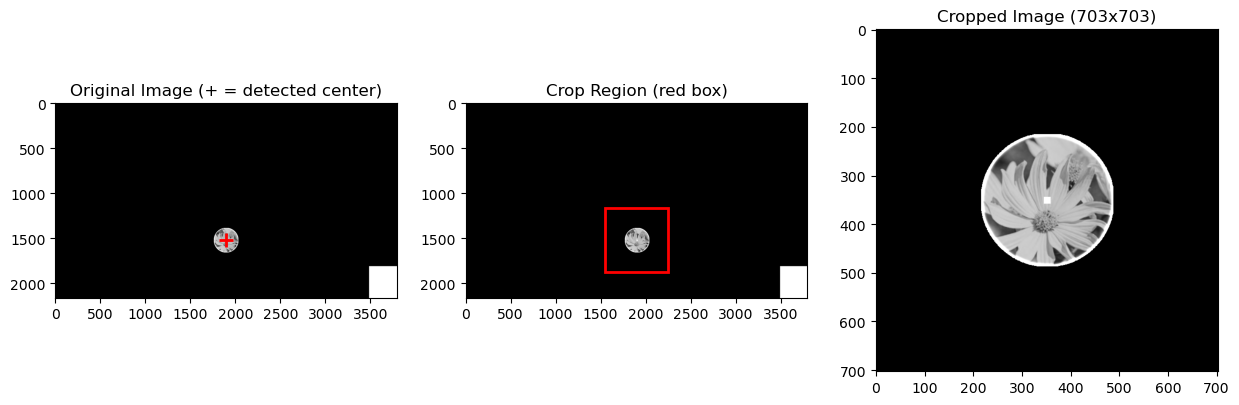

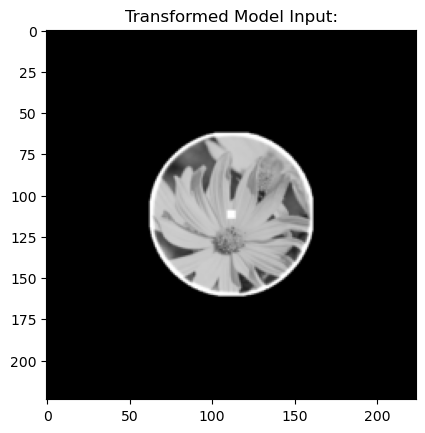

In [68]:
# Check crop
x = crop_around_center(Image.open(img_paths[0]).convert('RGB'), center_x, center_y, crop_size)

manual_crop_around_point(Image.open(img_paths[0]).convert('RGB'), center_x, center_y, crop_size)

plt.show()

fig, ax = plt.subplots()
ax.imshow(transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])(x))
ax.set_title('Transformed Model Input:')
plt.show()

In [69]:
# RUST CENTER = 1900, 1520

In [70]:
notes = f'\nFixation-point cropped images \nCenter: ({center_x}, {center_y}), Size: {crop_size}'

In [71]:
print(f'Layer subset: max({layer_subset_size}, {layer_subset_portion*100}%) features')

Layer subset: max(1000, 0%) features


In [72]:
# Run models, get activations, RDM dicts
start = time.time()

model_to_activations = {}
model_to_rdm_dict = {}

def get_activation(name, sample=False):
    def hook(model, input, output):
        # Flatten the activation and convert to numpy
        if sample is True: # Assumes have already create layer_to_idx
            activations[name] = output.detach().flatten()[layer_to_idx[name]].cpu().numpy()
        else:
            activations[name] = output.detach().cpu().numpy().flatten()
    return hook

for model_name in model_names:
    # Variable that indicates needing dummies for latent prediction
    latent = False
    
    # Load model
    if model_name in list(SBarlow_to_ckpt.keys()):
        model = BarlowTwinsLightningModule.load_from_checkpoint(SBarlow_to_ckpt[model_name]).model
    elif model_name in list(SObj_to_ckpt.keys()):
        model = ObjectClassificationLightningModule.load_from_checkpoint(SObj_to_ckpt[model_name]).model
    elif model_name in list(SLatent_to_ckpt.keys()):
        model = LatentPredictionLightningModule.load_from_checkpoint(
            SLatent_to_ckpt[model_name],
            strict=False).model
        latent = True
    elif model_name in list(SL_to_model.keys()):
        model = load_SL_model(SL_to_model[model_name])
    elif model_name == 'untrained_resnet50':
        model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=None)
    elif model_name == 'resnet50':
        model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=ResNet50_Weights.DEFAULT)
    elif model_name == 'barlow':
        model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
    elif model_name == 'resnet34':
        model = torchvision.models.resnet34(pretrained=True)
    elif model_name == 'resnet18':
        model = torchvision.models.resnet18(pretrained=True) 
    
    # Set device, set model to eval
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    # Df to store all results
    model_activations = pd.DataFrame(index=img_paths, columns=layer_names)
    
    # Set up hooks + activations to get layer_subset_idx
    if sample_layers is True:
        activations = {}
        hooks = []
        # Pass dummy tensor without sampling
        for name, layer in model.named_modules():
            if name in layer_names:
                hook = layer.register_forward_hook(get_activation(name, sample=False))
                hooks.append(hook)
        layer_to_idx = {}
        dummy_input = torch.randn(1, 3, 224, 224).to(device)
        if latent:
            dummies = torch.zeros(1, model.side_info_dim, 1).to(device) # assuming batch size 1
            _ = model(dummy_input, dummies)
        else:
            _ = model(dummy_input)
        for name, vect in activations.items():
            features_subset = max(layer_subset_size, int(len(vect)*layer_subset_portion))
            print(f'{name}: chose {features_subset} of {len(vect)} features')
            layer_to_idx[name] = np.random.choice(len(vect), size=features_subset, replace=False)
        # Remove hooks
        for hook in hooks:
            hook.remove()
    
    # Set up hooks for all layers
    activations = {}
    hooks = []
    for name, layer in model.named_modules():
        if name in layer_names:
            hook = layer.register_forward_hook(get_activation(name, sample=sample_layers))
            hooks.append(hook)

    # Process each image
    with torch.no_grad():
        if latent:
            with ThreadPoolExecutor(max_workers=cores*2) as executor:
                results = list(executor.map(process_image_latent, img_paths))
        else:    
            with ThreadPoolExecutor(max_workers=cores*2) as executor:
                results = list(executor.map(process_image, img_paths))
        for hook in hooks:
            hook.remove()
        # Store results
        for path, activation_data in results:
            model_activations.loc[path] = activation_data
    print('Done processing images...')
    
    # Create DataFrame, save activations
    model_to_activations[model_name] = model_activations
    print(f'Done with {model_name}')

end = time.time()
runtime = end-start
process = 'Model activations'
process_to_runtime[process] = runtime
print(f'Runtime: {runtime:.4f}s')

Using cache found in /home/pt2636/.cache/torch/hub/pytorch_vision_v0.10.0


layer1.0.conv3: chose 1000 of 802816 features
layer1.1.conv3: chose 1000 of 802816 features
layer1.2.conv3: chose 1000 of 802816 features
layer2.0.conv3: chose 1000 of 401408 features
layer2.1.conv3: chose 1000 of 401408 features
layer2.2.conv3: chose 1000 of 401408 features
layer2.3.conv3: chose 1000 of 401408 features
layer3.0.conv3: chose 1000 of 200704 features
layer3.1.conv3: chose 1000 of 200704 features
layer3.2.conv3: chose 1000 of 200704 features
layer3.3.conv3: chose 1000 of 200704 features
layer3.4.conv3: chose 1000 of 200704 features
layer3.5.conv3: chose 1000 of 200704 features
layer4.0.conv3: chose 1000 of 100352 features
layer4.1.conv3: chose 1000 of 100352 features
layer4.2.conv3: chose 1000 of 100352 features
avgpool: chose 1000 of 2048 features
Done processing images...
Done with untrained_resnet50


Using cache found in /home/pt2636/.cache/torch/hub/pytorch_vision_v0.10.0


layer1.0.conv3: chose 1000 of 802816 features
layer1.1.conv3: chose 1000 of 802816 features
layer1.2.conv3: chose 1000 of 802816 features
layer2.0.conv3: chose 1000 of 401408 features
layer2.1.conv3: chose 1000 of 401408 features
layer2.2.conv3: chose 1000 of 401408 features
layer2.3.conv3: chose 1000 of 401408 features
layer3.0.conv3: chose 1000 of 200704 features
layer3.1.conv3: chose 1000 of 200704 features
layer3.2.conv3: chose 1000 of 200704 features
layer3.3.conv3: chose 1000 of 200704 features
layer3.4.conv3: chose 1000 of 200704 features
layer3.5.conv3: chose 1000 of 200704 features
layer4.0.conv3: chose 1000 of 100352 features
layer4.1.conv3: chose 1000 of 100352 features
layer4.2.conv3: chose 1000 of 100352 features
avgpool: chose 1000 of 2048 features
Done processing images...
Done with resnet50


Using cache found in /home/pt2636/.cache/torch/hub/facebookresearch_barlowtwins_main
/home/pt2636/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pt2636/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


layer1.0.conv3: chose 1000 of 802816 features
layer1.1.conv3: chose 1000 of 802816 features
layer1.2.conv3: chose 1000 of 802816 features
layer2.0.conv3: chose 1000 of 401408 features
layer2.1.conv3: chose 1000 of 401408 features
layer2.2.conv3: chose 1000 of 401408 features
layer2.3.conv3: chose 1000 of 401408 features
layer3.0.conv3: chose 1000 of 200704 features
layer3.1.conv3: chose 1000 of 200704 features
layer3.2.conv3: chose 1000 of 200704 features
layer3.3.conv3: chose 1000 of 200704 features
layer3.4.conv3: chose 1000 of 200704 features
layer3.5.conv3: chose 1000 of 200704 features
layer4.0.conv3: chose 1000 of 100352 features
layer4.1.conv3: chose 1000 of 100352 features
layer4.2.conv3: chose 1000 of 100352 features
avgpool: chose 1000 of 2048 features
Done processing images...
Done with barlow
Runtime: 60.1014s


In [75]:
check_rss()

Current RSS usage: 8.76 GB
RSS limit: 96.00 GB (soft), 96.00 GB (hard)


In [74]:
x = os.path.join(locker_path, 'Data/hvm/ventral_neural_data.hdf5')
f = h5py.File(x, 'r')
dset_labels = f['image_meta']['object_name']
dset_neural = f['time_averaged_trial_averaged']

In [236]:
# Match up HvM images

import hashlib
from pathlib import Path

# marm hvm paths
marm_hvm_paths = []
marm_hvm_folder = os.path.join(locker_path, 'Data/hvm/hvm10_filenames')
for root, dirs, files in os.walk(marm_hvm_folder):
    for file in files:
        if file.endswith('.png'):
            marm_hvm_paths.append(os.path.join(root, file))

# macaque hvm paths and arr
macaque_hvm_arr = f['images']
macaque_hvm_paths = []
macaque_hvm_folder = os.path.join(locker_path, 'users/Parsa/macaque_data/HvM_images')
def get_ordered_filenames(folder_path):
    """Get filenames ordered by index at beginning of filename"""
    folder = Path(folder_path)
    
    # Get all files
    files = [f for f in folder.iterdir() if f.is_file()]
    
    # Sort by extracting the index number
    def extract_index(filepath):
        filename = filepath.name
        try:
            # Split by underscore and get first part as integer
            return int(filename.split('_')[0])
        except (ValueError, IndexError):
            # If no valid index, put at end
            return float('inf')
    
    # Sort by index
    sorted_files = sorted(files, key=extract_index)
    
    # Return just the filenames (or full paths if needed)
    return [f.name for f in sorted_files]

macaque_hvm_paths = get_ordered_filenames(macaque_hvm_folder)

def create_hash_index(matrix_3d):
    """Create a hash lookup table for the matrix"""
    hash_to_index = {}
    
    for i in range(matrix_3d.shape[0]):
        hash_val = hashlib.sha256(matrix_3d[i].tobytes()).hexdigest()
        hash_to_index[hash_val] = i
    
    return hash_to_index

def check_images_in_matrix(image_paths, matrix_3d):
    """Check which images have matches in the matrix"""
    # Build hash index once
    hash_index = create_hash_index(matrix_3d)
    
    matches = []
    for img_path in image_paths:
        # Load and preprocess image
        img_array = np.array(Image.open(img_path)) # assuming is 256x256
        
        # Handle different image formats
        if len(img_array.shape) == 3:  # RGB
            img_array = np.mean(img_array, axis=2)  # Convert to grayscale
        
        # Ensure same dtype as matrix
        img_array = img_array.astype(matrix_3d.dtype)
        
        # Check for match
        img_hash = hashlib.sha256(img_array.tobytes()).hexdigest()
        if img_hash in hash_index:
            matches.append((img_path, hash_index[img_hash]))
    
    return matches

# Usage
matches = check_images_in_matrix(marm_hvm_paths, macaque_hvm_arr)
print(f"Found {len(matches)} matches: {matches}")

marmoset_macaque_matches = []
for marm_path, mac_idx in matches:
    mac_hvm_path = os.path.join(macaque_hvm_folder, macaque_hvm_paths[mac_idx])
    marmoset_macaque_matches.append((marm_path, mac_hvm_path))
    
matches_path = os.path.join(locker_path, 'users/Parsa/macaque_data/HvM_marm_macaque_matches.pkl')
with open(matches_path, 'wb') as matches_file:
    pickle.dump(marmoset_macaque_matches, matches_file)

In [103]:
torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=ResNet50_Weights.DEFAULT)

Using cache found in /home/pt2636/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [84]:
# functions for saving + loading activations (note need to loop across model_names)
def save_activations(model_name, imageset, directory, model_to_activations):
    path = os.path.join(directory, f'{imageset}_{model_name}.h5')
    model_to_activations[model_name].to_hdf(path, key='data', mode='w')

def load_activations(model_name, imageset, directory):
    path = os.path.join(directory, f'{imageset}_{model_name}.h5')
    return pd.read_hdf(path, key='data')

# Save model activations
if save_activations is True:
    for model_name in model_names:
        save_activations(model_name, imageset, activations_dir, model_to_activations)
        print(f'Saved {model_name}')

In [85]:
# Monitor resources
# Create a stop event
stop_event = threading.Event()

def monitor_resources():
    """Monitor CPU and I/O usage"""
    while not stop_event.is_set():  # Check if we should stop
        cpu_percent = psutil.cpu_percent(interval=1)
        io_counters = psutil.disk_io_counters()
        memory = psutil.virtual_memory()
        
        print(f"CPU: {cpu_percent}% | Memory: {memory.percent}% | "
              f"Disk Read: {io_counters.read_bytes/1024/1024:.1f}MB | "
              f"Disk Write: {io_counters.write_bytes/1024/1024:.1f}MB")
        
        # Use wait instead of sleep so we can be interrupted
        stop_event.wait(2)  # Wait 2 seconds or until stop_event is set

# Start monitoring
monitor_thread = threading.Thread(target=monitor_resources, daemon=True)
monitor_thread.start()

# Stop monitoring
stop_event.set()
monitor_thread.join()  # Wait for thread to finish
print("Monitoring stopped")
# Set area, depth cutoff
area = 'All'
depth_cutoff = None

CPU: 0.7% | Memory: 6.5% | Disk Read: 23998.1MB | Disk Write: 1657381.6MB
Monitoring stopped


In [86]:
# Add neural data, calculate RDMs
start = time.time()

ch_shr_dict = {}
shr_dict = {}
error_dict = {}
ch_count_dict = {}
area_to_rdm = {}

# Check to add whole brain to RDMs
if add_whole_brain:
    area_cutoff_dict['All'] = ''

# Get max_ch_count
for area, depth_cutoff in area_cutoff_dict.items():
    if area=='All':
        cutoff_area_mask = cutoff_df['area']==area
    else:
        cutoff_area_mask = (cutoff_df['depth_cutoff']==depth_cutoff) & (cutoff_df['area']==area)
    row_idx = cutoff_area_mask[cutoff_area_mask].index[0]
    ch_count = cutoff_df.at[row_idx, 'channels_used']
    ch_count_dict[area] = ch_count

min_ch_count = min(ch_count_dict.values())

for area, depth_cutoff in area_cutoff_dict.items():
    if area=='All':
        cutoff_area_mask = cutoff_df['area']==area
    else:
        cutoff_area_mask = (cutoff_df['depth_cutoff']==depth_cutoff) & (cutoff_df['area']==area)
    row_idx = cutoff_area_mask[cutoff_area_mask].index[0]
    neural = cutoff_df.at[row_idx, 'trial_avg_series']
    ch_shr = cutoff_df.at[row_idx, 'ch_shr']
    rdm_shr = cutoff_df.at[row_idx, 'single_RDM_shr']
    rdm_shr_err = cutoff_df.at[row_idx, 'RDM_error']
    ch_shr_dict[area] = ch_shr
    shr_dict[area] = rdm_shr
    error_dict[area] = rdm_shr_err
    print(f'{area} {depth_cutoff} SHR: {rdm_shr:.2f}, Error: {rdm_shr_err:.2f}, Avg Channel SHR: {sum(ch_shr)/len(ch_shr):.2f}')
    area_to_rdm[area] = rdm(np.vstack(neural.values).astype(np.float32))
    if update_neural is True:
        for model_name in model_names:
            # Create + save rdm to rdm_dict
            responses = model_to_activations[model_name]
            responses[area] = neural
            resp_dict = {}
            for col in responses.columns:
                if equal_ch_count and col in areas:
                    ch_idx = np.random.choice(ch_count_dict[col], 
                                              size=min_ch_count,
                                              replace=False)
                    resp_dict[col] = np.vstack(responses[col].values).astype(np.float32)[:, ch_idx]
                else:
                    resp_dict[col] = np.vstack(responses[col].values).astype(np.float32)
            rdm_dict = {label: rdm(resp) for label, resp in resp_dict.items()}
            model_to_rdm_dict[model_name] = rdm_dict
            print(f'Done with {model_name}')
            
end = time.time()
runtime = end-start
process = 'Calculate RDMs'
process_to_runtime[process] = runtime
print(f'Runtime: {runtime:.4f}s')

TE0 labeled SHR: 0.79, Error: 0.01, Avg Channel SHR: 0.57
Done with untrained_resnet50
Done with resnet50
Done with barlow
TE2 labeled SHR: 0.66, Error: 0.01, Avg Channel SHR: 0.50
Done with untrained_resnet50
Done with resnet50
Done with barlow
TE3 labeled SHR: 0.59, Error: 0.02, Avg Channel SHR: 0.50
Done with untrained_resnet50
Done with resnet50
Done with barlow
Runtime: 4.5994s


In [87]:
# Get RDM correlations, store in nested_rdm_fits
neural_keys = areas

nested_rdm_fits = {layer: {key: {} for key in neural_keys} for layer in layer_names}
nested_rdm_errors = {layer: {key: {} for key in neural_keys} for layer in layer_names}

for row, layer in enumerate(layer_names):
    neural_to_model_fit = {key: {} for key in neural_keys}  # Initialize dict for each neural key
    
    for (model, model_dict) in model_to_rdm_dict.items():
        # Compute correlations for this row
        rdm_dict = model_dict.copy()
        
        # Pop all neural keys and compute correlations
        for neural_key in neural_keys:
            if neural_key in rdm_dict:
                rdm_neural = rdm_dict.pop(neural_key)
                shr = 1
                error = error_dict[neural_key]
                if normalize_by_shr:
                    shr = shr_dict[neural_key]
                neural_to_model_fit[neural_key][model] = correlate_rdms(rdm_neural, rdm_dict[layer]) / shr
    nested_rdm_fits[layer] = neural_to_model_fit

In [88]:
# Get inter-area RDM correlations
if len(area_to_rdm) > 1:
    extras = {}
    if normalize_by_shr:
        for (area1, rdm1), (area2, rdm2) in itertools.combinations(area_to_rdm.items(), 2):
            new_key = f'Norm {area1}-{area2} Corr'  # or however you want to combine keys
            extras[new_key] = correlate_rdms(rdm1, rdm2)/math.sqrt(shr_dict[area1]*shr_dict[area2])
    else:
        for (area1, rdm1), (area2, rdm2) in itertools.combinations(area_to_rdm.items(), 2):
            new_key = f'{area1}-{area2} Corr'  # or however you want to combine keys
            extras[new_key] = correlate_rdms(rdm1, rdm2)

extras_strs = [f'{key}: {value}' for key, value in extras.items()]
print('\n'.join(extras_strs))

Norm TE0-TE2 Corr: 0.2330243430789498
Norm TE0-TE3 Corr: 0.3080909930380076
Norm TE2-TE3 Corr: 0.44845664211648195


In [89]:
def vectorized_pearsonr(X, Y):
    """
    Compute Pearson correlation coefficients between corresponding columns of X and Y.
    
    Parameters:
    -----------
    X, Y: arrays of shape (n_samples, n_features)
    
    Returns:
    --------
    correlations: array of shape (n_features,)
    """
    # Center the data
    X_centered = X - np.mean(X, axis=0)
    Y_centered = Y - np.mean(Y, axis=0)
    
    # Compute correlations vectorized
    numerator = np.sum(X_centered * Y_centered, axis=0)
    X_std = np.sqrt(np.sum(X_centered**2, axis=0))
    Y_std = np.sqrt(np.sum(Y_centered**2, axis=0))
    
    # Avoid division by zero
    denominator = X_std * Y_std
    correlations = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)
    
    return correlations

def lr_encoding_fits(neural_data, model_data, 
                     return_errors=False,
                     sh_arr=None, var_cutoff=1e-6, folds=3, alphas_list=[.01,.1,1,10]):
    '''
    Parameters:
    ----------
    neural_data: dict/pd.Series with indices as image labels, activations in each cell as list/array
    model_data: ^  (assumes consistent feature count)
    sh_arr: split halves reliability of each feature in neural data
    var_cutoff: variance cutoff for removing a channels to prevent unstable regression output
    split: image or trial (ensures same trial count per image per split)
    folds: for splits
    alphas: for regression
    -----------
    Returns: scores as a 1D array, with each entry corresponding to a channel
            error (optional): array of std for each channel across folds) 
    '''
    
    # Align the series by their indices
    common_indices = neural_data.index.intersection(model_data.index)
    neural_aligned = neural_data.loc[common_indices]
    model_aligned = model_data.loc[common_indices]
    
    # Convert activation vectors to arrays (stim x feat)
    model_activ = np.vstack(model_aligned.values)  # Features (model activations)
    neural_activ = np.vstack(neural_aligned.values)  # Targets (neural activations)
    
    # Remove constant channels
    var_mask = np.var(neural_activ, axis=0) < var_cutoff
    neural_activ = neural_activ[: , ~var_mask]
    
    # Get channel count
    ch_count = neural_activ.shape[1]
    
    # Initialize k-fold cross-validation
    kfold = KFold(n_splits=folds, shuffle=True)
    
    # Create variables to store regression data
    train_scores = np.zeros((folds, ch_count))
    scores = np.zeros((folds, ch_count))
    alphas = np.zeros((folds, ch_count))
    
    # Conduct regressions
    for fold, (train_indices, test_indices) in enumerate(kfold.split(model_activ)):
        model = RidgeCV(alphas=alphas_list).fit(model_activ[train_indices], neural_activ[train_indices])
        test_predictions = model.predict(model_activ[test_indices])
        train_predictions = model.predict(model_activ[train_indices])
        neural_test = neural_activ[test_indices]
        neural_train = neural_activ[train_indices]
        
        # Vectorized correlation calculation for test scores
        scores[fold, :] = vectorized_pearsonr(neural_test, test_predictions)
        
        # Vectorized correlation calculation for train scores  
        train_scores[fold, :] = vectorized_pearsonr(neural_train, train_predictions)
        
        # Store model alphas
        alphas[fold, :] = model.alpha_
    
    # Store error:
    if return_errors:
        errors = np.std(scores, axis=0)
    
    # Average across folds
    scores = np.mean(scores, axis=0)
    
    # Normalize by split-halves
    if sh_arr is not None:
        norm_coeff = (2 * np.array(sh_arr[~var_mask])) / (sh_arr[~var_mask] + 1)
        scores = scores / norm_coeff
    
    if return_errors:
        return scores, errors
    else:
        return scores

In [90]:
# Get nested 'layer : area : model : fit' dictionary
# Note: uses model_names and layer_names, does not intepret from data
nested_regression_fits = {layer: {area: {} for area in areas} for layer in layer_names}
nested_regression_errors = {layer: {area: {} for area in areas} for layer in layer_names}

start = time.time()
for model, activation_df in model_to_activations.items():
    print(f'Starting {model}...')
    for area in areas:
        neural_data = activation_df[area]
        area_ch_shr = ch_shr_dict[area] 
        for layer in tqdm(layer_names):
            model_data = activation_df[layer]
            encoding_scores = lr_encoding_fits(neural_data, model_data, sh_arr=area_ch_shr)
            ch_count = len(encoding_scores)
            nested_regression_fits[layer][area][model] = np.mean(encoding_scores)
            nested_regression_errors[layer][area][model] = np.std(encoding_scores)/math.sqrt(ch_count)
        # Add model name to area values
        print(f'Finished {area}')

end = time.time()
runtime = end-start
process = ''
process_to_runtime[process] = runtime
print(f'Runtime: {runtime:.4f}s')

Starting untrained_resnet50...


100%|██████████| 17/17 [00:01<00:00, 12.46it/s]


Finished TE0


100%|██████████| 17/17 [00:00<00:00, 27.29it/s]


Finished TE2


100%|██████████| 17/17 [00:00<00:00, 24.32it/s]


Finished TE3
Starting resnet50...


100%|██████████| 17/17 [00:01<00:00, 12.56it/s]


Finished TE0


100%|██████████| 17/17 [00:00<00:00, 29.26it/s]


Finished TE2


100%|██████████| 17/17 [00:00<00:00, 25.26it/s]


Finished TE3
Starting barlow...


100%|██████████| 17/17 [00:01<00:00, 12.63it/s]


Finished TE0


100%|██████████| 17/17 [00:00<00:00, 29.26it/s]


Finished TE2


100%|██████████| 17/17 [00:00<00:00, 25.48it/s]

Finished TE3
Runtime: 7.9114s


In [170]:
# Different combinations to check
early_vs_late = {'early': ['layer1', 'layer2'],
             'late': ['layer3', 'layer4', 'avgpool']}
selfsup_vs_sup = {
    'Self Supervised': ['barlow', 'objectome_bt_100', 
                        'objectome_lp_ph_ait_good_params_100', 'SSRN50_FT_4id_7em',],
    'Supervised': ['objectome_scene_class', 'objectome_obj_class', 'RN50 FT_4cid_7em', 'resnet50']
}

object_vs_scene = ['objectome_scene_class', 'objectome_obj_class']

In [121]:
# Parameters:

# Plot order: axes, groups, bars
subplot_order = ['model', 'neural', 'layer']

subsets = {
    'neural': None,
    'layer': {
        layer: [sublayer for sublayer in layer_names if sublayer.startswith(layer)] 
        for layer in ['layer1', 'layer2', 'layer3', 'layer4', 'avgpool']
    },
    'model': ['resnet50', 'barlow']
}

subplot_labels = {
    'neural': None,
    'layer': f'Bneck Avg',
    'model': None
}

fit_data = {
    'RDM': (nested_rdm_fits, nested_rdm_errors),
    'regression': (nested_regression_fits, nested_regression_errors)
}

In [122]:
def switch_nesting_order(data, new_order=['inner', 'middle', 'outer']):
    """
    Switch the nesting order of a 3-level dictionary.
    
    Args:
        data: Dictionary with structure {outer: {middle: {inner: value}}}
        new_order: List of 3 strings specifying new nesting order 
                  (e.g., ['inner', 'outer', 'middle'])
    
    Returns:
        Dictionary with switched nesting order
    """
    result = {}
    
    for outer_key, middle_dict in data.items():
        for middle_key, inner_dict in middle_dict.items():
            for inner_key, value in inner_dict.items():
                
                # Map current keys to new positions
                key_map = {
                    'outer': outer_key,
                    'middle': middle_key, 
                    'inner': inner_key
                }
                
                # Build nested structure according to new_order
                current = result
                for i, level in enumerate(new_order):
                    key = key_map[level]
                    if i == len(new_order) - 1:  # Last level - assign value
                        current[key] = value
                    else:  # Intermediate level - ensure dict exists
                        if key not in current:
                            current[key] = {}
                        current = current[key]
    
    return result

In [123]:
def average_level_keys(data, grouping_dict, target_level='inner'):
    """
    Average values across specified keys at any nesting level, preserving order.
    
    Args:
        data: Dictionary with structure {outer: {middle: {inner: value}}}
        grouping_dict: Dict mapping new keys to lists of existing keys to average
        target_level: Which level to average ('inner', 'middle', or 'outer')
    """
    def avg_values(dicts, key):
        values = [d[key] for d in dicts if key in d]
        return sum(values) / len(values) if values else None
    
    result = {}
    
    if target_level == 'inner':
        for outer_key, middle_dict in data.items():
            result[outer_key] = {}
            for middle_key, inner_dict in middle_dict.items():
                result[outer_key][middle_key] = {}
                for new_key, keys in grouping_dict.items():
                    values = [inner_dict[k] for k in keys if k in inner_dict]
                    if values:
                        result[outer_key][middle_key][new_key] = sum(values) / len(values)
    
    elif target_level == 'middle':
        for outer_key, middle_dict in data.items():
            result[outer_key] = {}
            for new_key, keys in grouping_dict.items():
                middle_dicts = [middle_dict[k] for k in keys if k in middle_dict]
                if middle_dicts:
                    result[outer_key][new_key] = {}
                    # Preserve order from first dict
                    for inner_key in middle_dicts[0].keys():
                        if (avg := avg_values(middle_dicts, inner_key)) is not None:
                            result[outer_key][new_key][inner_key] = avg
    
    elif target_level == 'outer':
        for new_key, keys in grouping_dict.items():
            outer_dicts = [data[k] for k in keys if k in data]
            if outer_dicts:
                result[new_key] = {}
                # Preserve order from first dict
                for middle_key in outer_dicts[0].keys():
                    middle_dicts = [d[middle_key] for d in outer_dicts if middle_key in d]
                    if middle_dicts:
                        result[new_key][middle_key] = {}
                        for inner_key in middle_dicts[0].keys():
                            if (avg := avg_values(middle_dicts, inner_key)) is not None:
                                result[new_key][middle_key][inner_key] = avg
    
    else:
        raise ValueError("target_level must be 'inner', 'middle', or 'outer'")
    
    return result

In [124]:
def plot_nested_dict(data, title='', xlabel='', ylabel='', errors=None, extras=None, figsize=None,
                    subset_dict={}):
    """
    Plots a nested dictionary of the form {outer: {middle: {inner: float}}}
    
    - One subplot per `outer` key (e.g., area)
    - Bars for `inner` keys grouped by `middle` keys (e.g., method)
    - Shows values on bars
    - Shows average lines per group and global average line
    
    Parameters:
        data (dict): The nested dictionary to plot
        title (str): Title of the plot
        xlabel (str):
        ylabel (str):
        errors (dict): Nested dictionary with errors for each float
        extras (dict): Labeled values to plot on each axis
        figsize(tuple): 
    """
    # Select keys based on subset keys
    outer_keys = (list(data.keys()) if subset_dict.get('outer') is None 
                 else [k for k in subset_dict['outer'] if k in data])
    all_middle_keys = list(dict.fromkeys(m for o in outer_keys for m in data[o].keys()))
    all_inner_keys = list(dict.fromkeys(i for o in outer_keys for m in data[o].values() for i in m))
    
    middle_keys = (all_middle_keys if subset_dict.get('middle') is None 
                  else [k for k in all_middle_keys if k in set(subset_dict['middle'])])
    inner_keys = (all_inner_keys if subset_dict.get('inner') is None 
                 else [k for k in all_inner_keys if k in set(subset_dict['inner'])])
    
    # Count them
    n_outer = len(outer_keys)
    n_middle = len(middle_keys)
    n_inner = len(inner_keys)
    
    x = np.arange(n_middle)
    width = 0.8 / n_inner
    
    if figsize is None:
        figsize=(n_middle * 1.5, n_outer * 6)
    fig, axes = plt.subplots(n_outer, 1, figsize=figsize, sharey=True)
    if n_outer == 1:
        axes = [axes]

    colors = plt.cm.tab10.colors

    for i, outer_key in enumerate(outer_keys):
        ax = axes[i]
        for j, inner_key in enumerate(inner_keys):
            heights = [data[outer_key].get(m, {}).get(inner_key, 0) for m in middle_keys]
            yerr = None
            if errors:
                yerr = [errors[outer_key].get(m, {}).get(inner_key, 0) for m in middle_keys]

            bar_x = x + j * width - (n_inner - 1) * width / 2
            bars = ax.bar(bar_x, heights, width, label=inner_key, color=colors[j % len(colors)],
                          yerr=yerr, capsize=5)

            for i, bar in enumerate(bars):
                if errors:
                    h = bar.get_height() + yerr[i] + 0.01
                else:
                    h = bar.get_height()
                if h != 0:
                    ax.text(bar.get_x() + bar.get_width()/2, h, f'{h:.2f}',
                            ha='center', va='bottom', fontsize=8)

        # Add horizontal lines from extras
        if extras:
            for label, value in extras.items():
                ax.axhline(value, linestyle='--', label=label, linewidth=1)

        ax.set_title(str(outer_key))
        ax.set_xticks(x)
        ax.set_xticklabels(middle_keys, rotation=45, ha='right')
        if i == 0:
            ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)
        ax.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')

    fig.suptitle(title, y=1)
    fig.tight_layout()
    plt.subplots_adjust(right=0.85)
    return fig, axes

In [125]:
def plot_aggregated_bars(data, title='', xlabel='', ylabel='', subset_dict={}, figsize=(12, 6)):
    # Select keys based on subset keys
    outer_keys = (list(data.keys()) if subset_dict.get('outer') is None 
                 else [k for k in subset_dict['outer'] if k in data])
    all_middle_keys = list(dict.fromkeys(m for o in outer_keys for m in data[o].keys()))
    all_inner_keys = list(dict.fromkeys(i for o in outer_keys for m in data[o].values() for i in m))
    
    middle_keys = (all_middle_keys if subset_dict.get('middle') is None 
                  else [k for k in all_middle_keys if k in set(subset_dict['middle'])])
    inner_keys = (all_inner_keys if subset_dict.get('inner') is None 
                 else [k for k in all_inner_keys if k in set(subset_dict['inner'])])
    
    # Create plot
    width = 0.8 / len(middle_keys)
    x = np.arange(len(outer_keys))
    fig, ax = plt.subplots(figsize=figsize)
    colors = plt.cm.tab10.colors
    
    # Calculate and plot means + stderrs
    for i, middle in enumerate(middle_keys):
        means = []
        stderrs = []
        for outer in outer_keys:
            values = [
                data[outer][middle][inner]
                for inner in inner_keys
                if middle in data[outer] and inner in data[outer][middle]
            ]
            if values:
                mean = np.mean(values)
                stderr = np.std(values, ddof=1) / np.sqrt(len(values))
            else:
                mean = 0
                stderr = 0
            means.append(mean)
            stderrs.append(stderr)

        bar_x = x + i * width - (len(middle_keys) - 1) * width / 2
        bars = ax.bar(bar_x, means, width, label=middle, color=colors[i % len(colors)],
                      yerr=stderrs, capsize=5)

        for j, bar in enumerate(bars):
            if means[j] != 0:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + stderrs[j],
                        f'{means[j]:.2f}', ha='center', va='bottom', fontsize=8)
    
    # Set ticks and legend
    ax.set_xticks(x)
    ax.set_xticklabels(outer_keys, rotation=45, ha='right')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    fig.tight_layout()

    return fig, ax

In [114]:
# Generate parameters in title for plotting purposese
area_cutoff_str = ', '.join([f'{area}: {cutoff}' for area, cutoff in area_cutoff_dict.items()])
if equal_ch_count:
    ch_count_str = f'Equal Channel Count: {min_ch_count}'
else:
    ch_count_str = ', '.join([f'{area}: {ch_count} channels' for area, ch_count in ch_count_dict.items()])        
params_title = f'{imageset}\n{area_cutoff_str}\n{ch_count_str}\n{dec_column} decoding: {avg_dec_score:.2f}, {len(dates)} sessions\n Channel SH > {sh_limit}{notes}'

In [115]:
check_rss()

Current RSS usage: 7.78 GB
RSS limit: 96.00 GB (soft), 96.00 GB (hard)


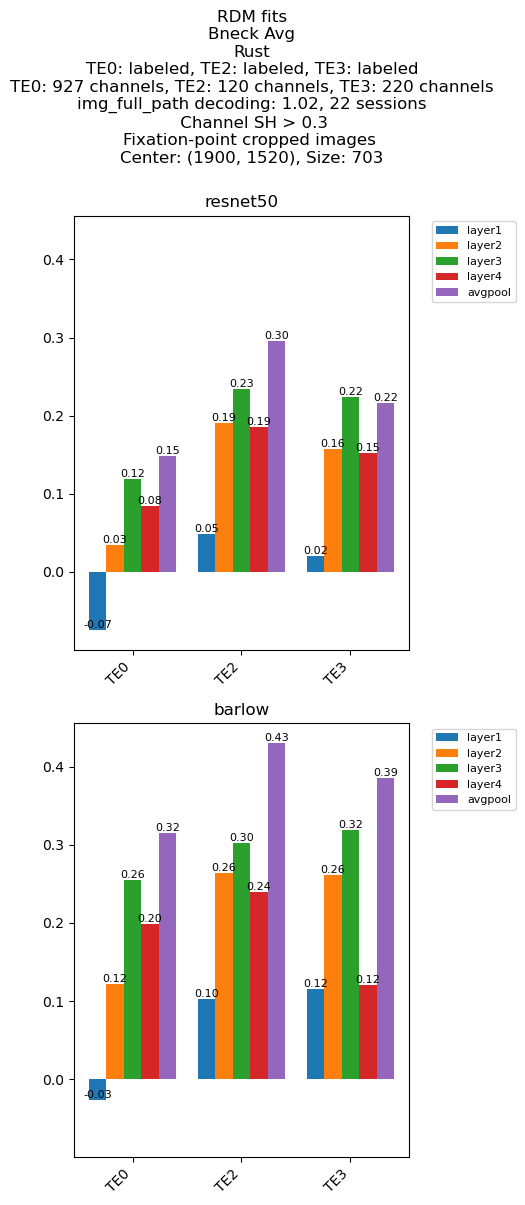

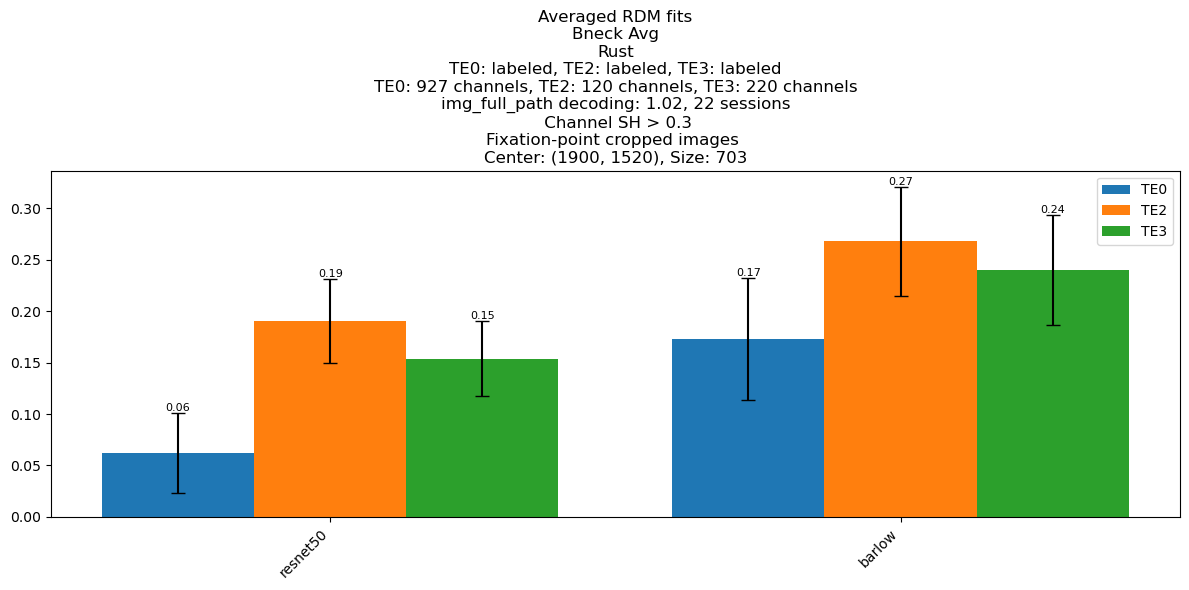

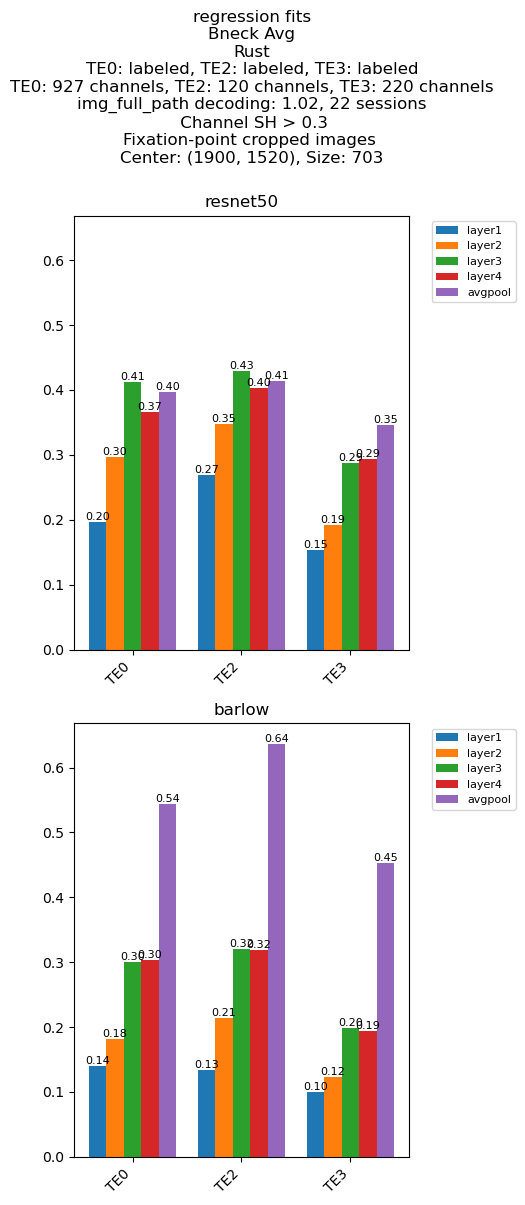

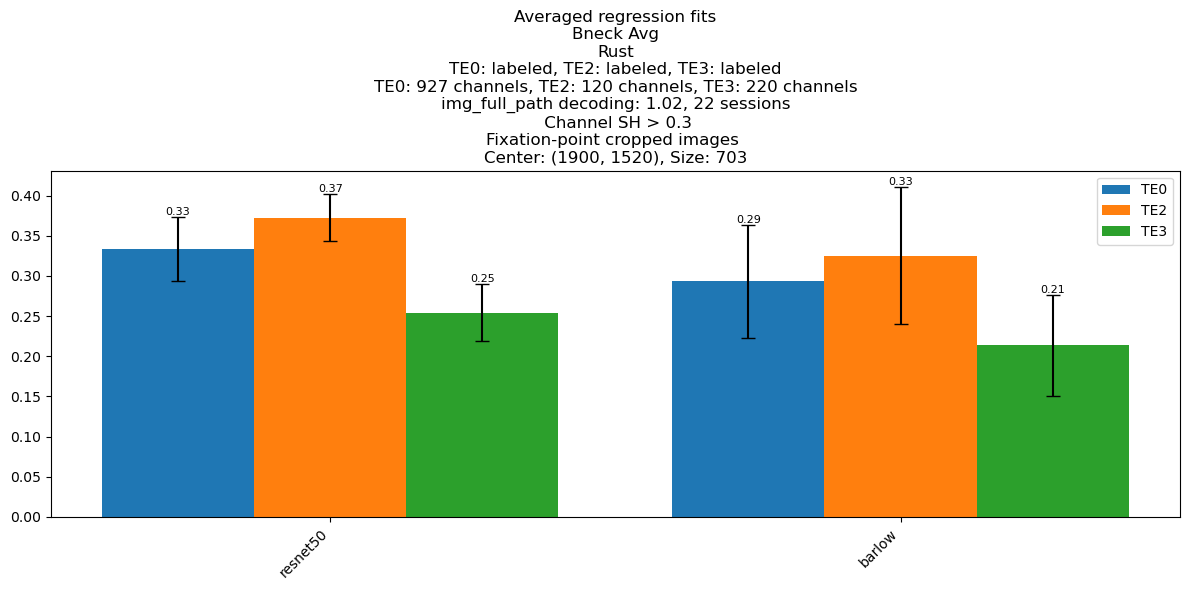

In [126]:
for analysis, (nested_fits, nested_errors) in fit_data.items():
    # Process each dimension according to subsets
    processed_data = nested_fits.copy()
    
    # Switch to desired plot_order
    current_order = {
       'layer': 'outer',
       'neural': 'middle', 
       'model': 'inner'
    }
    
    final_order = {
        x: y for x, y in zip(subplot_order, ['outer', 'middle', 'inner'])
    }
    
    subset_dict = {}
    
    for dim, subset_info in subsets.items():
        if isinstance(subset_info, dict):
            level = current_order[dim]
            # Use averaging for grouped keys
            processed_data = average_level_keys(processed_data, subset_info, target_level=level)
        elif isinstance(subset_info, list):
            level = final_order[dim]
            subset_dict[level] = subset_info
    
    new_order = [current_order[dim] for dim in subplot_order]
    ordered_rdm_fits = switch_nesting_order(processed_data, new_order)
    
    # Generate path f
    subplots_label = '_'.join(v for v in subplot_labels.values() if v!=None)
    subplot_dir_path = os.path.join(plot_dir_path, subplots_label)
    if not os.path.exists(subplot_dir_path):
        os.makedirs(subplot_dir_path)
    
    # Plot everything:
    title = f'{analysis} fits\n{subplots_label}\n{params_title}'
    
    plot_nested_dict(ordered_rdm_fits, subset_dict=subset_dict, title=title)
    plt.savefig(os.path.join(subplot_dir_path, f'{analysis}.png'))
    
    plot_aggregated_bars(ordered_rdm_fits, subset_dict=subset_dict, title=f'Averaged {title}')
    plt.savefig(os.path.join(subplot_dir_path, f'{analysis}_averaged.png'))

In [230]:
# Create barplot for regression fits
def create_nested_barplot(data, title=None, layer_names=None, model_names=None, area_names=None):
    # Extract all unique models and areas
    all_models = set()
    all_areas = set()
    for layer_data in data.values():
        all_models.update(layer_data.keys())
        for model_data in layer_data.values():
            all_areas.update(model_data.keys())
    
    # Allow for custom ordering of layers, models, areas
    if model_names is not None:
        models = model_names
    else:
        models = list(all_models)
    if area_names is not None:
        areas = area_names
    else:
        areas = list(all_areas)
    if layer_names is not None:
        layers = layer_names
    else:
        layers = list(data.keys())
    
    # Calculate averages
    averages = {}
    errors = {}
    for layer in layers:
        averages[layer] = {}
        errors[layer] = {}
        for model in models:
            averages[layer][model] = {}
            errors[layer][model] = {}
            for area in areas:
                if model in data[layer] and area in data[layer][model]:
                    ch_count = len(data[layer][model][area])
                    averages[layer][model][area] = np.mean(data[layer][model][area])
                    errors[layer][model][area] = np.std(data[layer][model][area])/math.sqrt(ch_count)
                else:
                    averages[layer][model][area] = 0
                    errors[layer][model][area] = 0
    
    # Set up the plot
    n_layers = len(layers)
    n_models = len(models)
    fig, axes = plt.subplots(n_layers, 1, figsize=(n_models, 5*n_layers))
    if title:
        fig.suptitle(title, fontsize=14, y=1)
    
    # If only one layer, axes won't be an array
    if n_layers == 1:
        axes = [axes]
    
    # Bar width and positions
    bar_width = 0.8 / len(areas)
    
    for i, layer in enumerate(layers):
        ax = axes[i]
        
        # X positions for model groups
        x_pos = np.arange(len(models))
        
        # Plot bars for each area
        for j, area in enumerate(areas):
            values = [averages[layer][model][area] for model in models]
            error_values = [errors[layer][model][area] for model in models]
            offset = (j - len(areas)/2 + 0.5) * bar_width
            
            bars = ax.bar(x_pos + offset, values, bar_width, 
                         label=area, alpha=0.8, yerr=error_values)
            
            # Add value labels on bars (optional)
            for k, bar in enumerate(bars):
                height = values[k]
                error = error_values[k]
                if height > 0:  # Only label non-zero bars
                    ax.text(bar.get_x() + bar.get_width()/2., height + error + 0.01,
                           f'{height:.2f}', ha='center', va='bottom', fontsize=7)
        
        # Customize the subplot
        ax.set_ylabel('Average Fit (All Channels)')
        ax.set_title(f'{layer}')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(models, rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        
        # Set y-axis limits for better visualization
        ax.set_ylim(0, max([max([averages[layer][model][area] 
                                for model in models for area in areas]) * 1.1, 1.0]))
    
    plt.tight_layout()
    
    return fig, axes, averages

title = f'Regression Neural Fits\n{params_title}'
# Create the plot
fig, axes, averages = create_nested_barplot(regression_nested_dict,
                                            title=title,
                                            model_names=model_names,
                                           area_names=areas)

if equal_ch_count:
    plt.savefig(os.path.join(plot_dir_path, 'equal_ch_layer_regression_fits.png'), bbox_inches='tight')
else:
    plt.savefig(os.path.join(plot_dir_path, 'layer_regression_fits.png'), bbox_inches='tight')

NameError: name 'regression_nested_dict' is not defined

In [ ]:
# Create barplot for model-averaged regression fits
def model_averaged_barplot(data, title=None, layer_names=None, area_names=None):
    # Extract all unique areas and layers
    all_areas = set()
    for layer_data in data.values():
        for model_data in layer_data.values():
            all_areas.update(model_data.keys())
    
    # Allow for custom ordering of layers, areas
    if area_names is not None:
        areas = area_names
    else:
        areas = list(all_areas)
    if layer_names is not None:
        layers = layer_names
    else:
        layers = list(data.keys())
    
    # Calculate averages across all models for each layer-area combination
    averages = {}
    errors = {}
    for layer in layers:
        averages[layer] = {}
        errors[layer] = {}
        for area in areas:
            # Collect all values for this layer-area combination across all models
            all_values = []
            for model in data[layer]:
                if area in data[layer][model]:
                    # Average the fits array for this model-area, then collect
                    model_area_avg = np.mean(data[layer][model][area])
                    all_values.append(model_area_avg)
            
            # Average across all models
            if all_values:
                averages[layer][area] = np.mean(all_values)
                errors[layer][area] = np.mean(all_values)/math.sqrt(len(all_values))
            else:
                averages[layer][area] = 0
                errors[layer][area] = 0
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Bar width and positions
    bar_width = 0.8 / len(areas)
    x_pos = np.arange(len(layers))
    
    # Plot bars for each area
    for i, area in enumerate(areas):
        values = [averages[layer][area] for layer in layers]
        error_values = [errors[layer][area] for layer in layers]
        offset = (i - len(areas)/2 + 0.5) * bar_width
        bars = ax.bar(x_pos + offset, values, bar_width, yerr=error_values, label=area)
        
        # Add value labels on bars
        for j, bar in enumerate(bars):
            height = values[j]
            error = error_values[j]
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height + error + 0.01,
                       f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    # Customize the plot
    ax.set_xlabel('Layers')
    ax.set_ylabel('Average Fit Value (Across All Models)')
    if title:
        ax.set_title(title)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(layers)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Set y-axis limits
    ax.set_ylim(0, 1)
    
    plt.tight_layout()
    
    return fig, ax, averages

title = f'Average Regression Fit Across Models\n{params_title}'

# Create the plot
fig, axes, averages = model_averaged_barplot(regression_nested_dict, title=title, area_names=areas)

if equal_ch_count:
    plt.savefig(os.path.join(plot_dir_path, 'equal_ch_modelavg_layer_regression_fits.png'), bbox_inches='tight')
else:
    plt.savefig(os.path.join(plot_dir_path, 'modelavg_layer_regression_fits.png'), bbox_inches='tight')

In [89]:
# Determine layers to plot
plot_layers = layer_names

In [ ]:
# Plot layer-wise fits
def plot_layers_fit(rdm_nested_dict, shr, error, layers, title, neural_keys=['Neural'], normalize=False, extras=None):
    '''
    rdm_nested_dict: nested dictionary that goes model:layer:RDM
    shr: can be single value or dict matching neural_keys
    error: error values - can be single value or dict/list matching neural_keys
    layers: list of layers to use RDMs
    neural_keys: list of keys to pop from each model dict (default: ['Neural'])
    extras: dict of values to be added to each ax (layer)
    '''
    
    n_rows = len(layers)
    n_cols = len(rdm_nested_dict)
    fig, axs = plt.subplots(n_rows, 1, figsize=(n_cols, 6 * n_rows))
    
    fig.suptitle(title, fontsize=14, y=1)
    
    # Handle single row case
    if n_rows == 1:
        axs = [axs]
    
    # Handle shr and error inputs - can be single values, dicts, or lists
    def get_value_for_key(param, key, default=None):
        if isinstance(param, dict):
            return param.get(key, default)
        elif isinstance(param, (list, tuple)):
            key_index = neural_keys.index(key) if key in neural_keys else 0
            return param[key_index] if key_index < len(param) else default
        else:
            return param
    
    best_fit = []
    for row, layer in enumerate(layers):
        model_to_fit = {key: {} for key in neural_keys}  # Initialize dict for each neural key
        
        for (model, model_dict) in rdm_nested_dict.items():
            # Compute correlations for this row
            rdm_dict = model_dict.copy()
            
            # Pop all neural keys and compute correlations
            for neural_key in neural_keys:
                if neural_key in rdm_dict:
                    rdm_neural = rdm_dict.pop(neural_key)
                    model_to_fit[neural_key][model] = correlate_rdms(rdm_neural, rdm_dict[layer])
        
        # Find best fit across all neural keys
        all_values = []
        
        # Create grouped bar plot
        models = list(rdm_nested_dict.keys())
        x = np.arange(len(models))
        width = 0.8 / len(neural_keys)  # Width of bars
        
        for i, neural_key in enumerate(neural_keys):
            values = [model_to_fit[neural_key].get(model, 0) for model in models]
            offset = (i - len(neural_keys)/2 + 0.5) * width
            if normalize:
                key_shr = shr if not isinstance(shr, dict) else shr[neural_key]
                # normalize values
                values = [v / key_shr for v in values]
                # add values to list (used for calculating max)
                all_values.extend(values)
                key_error = get_value_for_key(error, neural_key, 0) / key_shr
                bars = axs[row].bar(x + offset, values, width, label=neural_key, 
                            yerr=key_error, ecolor='black', alpha=0.8)                
            else:
                # add values to list (used for calculating max)
                all_values.extend(values)
                # Get error
                key_error = get_value_for_key(error, neural_key, 0)
                
                bars = axs[row].bar(x + offset, values, width, label=neural_key, 
                            yerr=key_error, ecolor='black', alpha=0.8)
                bar_color = bars[0].get_facecolor()  # Get color from the first bar in this group
                key_shr = shr if not isinstance(shr, dict) else shr[neural_key]
                if key_shr is not None:
                    axs[row].axhline(y=key_shr, color=bar_color, linestyle='--', linewidth=2, 
                                   alpha=0.7, label=f'SHR ({neural_key})' if len(neural_keys) > 1 else 'Split-half reliability')
        
        axs[row].axhline(y=max(all_values), color='blue', linestyle='--', linewidth=1, label='Max Corr across models')
        
        axs[row].set_xticks(x)
        axs[row].set_xticklabels(models, rotation=45, ha='right')
        axs[row].set_title(f'{layer}', fontsize=10)
        
        best_fit.append(max(all_values))
    # Add overall max fit line, along with legend + extra lines
    max_fit = max(best_fit)
    for ax in axs:
        ax.axhline(y=max_fit, color='grey', linestyle='--', linewidth=1, label='Overall max fit')
        if extras is not None:
            colors = plt.cm.Set1(np.linspace(0, 1, len(extras)))  # or 'Dark2', 'Accent'
            for i, (key, value) in enumerate(extras.items()):
                ax.axhline(y=value, color=colors[i], label=key)
        ax.legend(ncol=3)
        ax.set_ylim(0, 1)
    
    return fig, axs

title = f'RDM Layer Fits\n{params_title}'

plot_layers_fit(model_to_rdm_dict, 
                shr_dict, 
                error_dict, 
                plot_layers,
                title,
                neural_keys=list(area_cutoff_dict.keys()),
                normalize=normalize_by_shr,
                extras=extras)

plt.tight_layout()
if equal_ch_count:
    plt.savefig(os.path.join(plot_dir_path, 'equal_ch_layer_RDM_corrs.png'), bbox_inches='tight')
else:
    plt.savefig(os.path.join(plot_dir_path, 'layer_RDM_corrs.png'), bbox_inches='tight')

In [ ]:
# Plot single-model correlations
def plot_nested_correlations(rdm_nested_dict, shr, error, layers, title, neural_keys=['Neural']):
    """
    Plot correlations for nested dictionary with row suptitles.
    
    rdm_nested_dict: nested dictionary
    shr: split-halves reliability - can be single value or dict/list matching neural_keys
    error: error values - can be single value or dict/list matching neural_keys
    layers: list of model layers that should be plotted
    title: plot title
    neural_keys: list of keys to pop from each inner dict (default: ['Neural'])
    """
    
    # Handle shr and error inputs - can be single values, dicts, or lists
    def get_value_for_key(param, key, default=None):
        if isinstance(param, dict):
            return param.get(key, default)
        elif isinstance(param, (list, tuple)):
            key_index = neural_keys.index(key) if key in neural_keys else 0
            return param[key_index] if key_index < len(param) else default
        else:
            return param
    
    n_rows = len(rdm_nested_dict)
    
    fig, axs = plt.subplots(n_rows, 1, figsize=(7, 3.5 * n_rows))
    
    # Handle single row case
    if n_rows == 1:
        axs = [axs]
    
    for row, (row_key, inner_dict) in enumerate(rdm_nested_dict.items()):
        # Compute correlations for this row
        rdm_model = inner_dict.copy()
        
        # Store correlations for each neural key
        neural_correlations = {}
        
        # Pop all neural keys and compute correlations
        for neural_key in neural_keys:
            if neural_key in rdm_model:
                rdm_model_copy = rdm_model.copy()  # Make a fresh copy for each neural key
                rdm_neural = rdm_model_copy.pop(neural_key)
                neural_correlations[neural_key] = {label: correlate_rdms(rdm_neural, rdm) 
                                                 for label, rdm in rdm_model_copy.items()}
        
        # Get all model labels (should be same across neural keys)
        model_labels = layers
        
        # Create grouped bar plot
        x = np.arange(len(model_labels))
        width = 0.8 / len(neural_keys)  # Width of bars
        
        for i, neural_key in enumerate(neural_keys):
            if neural_key in neural_correlations:
                values = [neural_correlations[neural_key][label] for label in model_labels]
                offset = (i - len(neural_keys)/2 + 0.5) * width
                
                # Get error for this specific key
                key_error = get_value_for_key(error, neural_key, 0)
                
                bars = axs[row].bar(x + offset, values, width, label=neural_key, 
                                   yerr=key_error, ecolor='black', alpha=0.8)
                
                # Add SHR line with matching color
                bar_color = bars[0].get_facecolor()
                key_shr = shr if not isinstance(shr, dict) else shr[neural_key]
                if key_shr is not None:
                    axs[row].axhline(y=key_shr, color=bar_color, linestyle='--', linewidth=2, 
                                   alpha=0.7, label=f'SHR ({neural_key})' if len(neural_keys) > 1 else 'Split-half reliability')
        
        axs[row].set_ylim(0, 1)
        axs[row].set_xticks(x)
        axs[row].set_xticklabels(model_labels, rotation=45, ha='right')
        axs[row].set_title(f'{row_key} ~ Neural RDM Corrs', fontsize=10)
        axs[row].legend()
    
    plt.suptitle(title, y=1)
    
    plt.tight_layout()

title = f'Model Specific Corr\n{params_title}'
plot_nested_correlations(model_to_rdm_dict, 
                         shr_dict, 
                         error_dict, 
                         plot_layers,
                         title, 
                         neural_keys=list(area_cutoff_dict.keys()))

if equal_ch_count:
    plt.savefig(os.path.join(plot_dir_path, 'equal_ch_model_RDM_corrs.png'), bbox_inches='tight')
else:
    plt.savefig(os.path.join(plot_dir_path, 'model_RDM_corrs.png'), bbox_inches='tight')
plt.show()

In [ ]:
# Plot RDMs

def plot_corr_matrix(rdm, ax=None, show=False):
    """Plot dissimilarity matrix
  
    Args:
      rdm (numpy array): n_stimuli x n_stimuli representational dissimilarity
        matrix
      ax (matplotlib axes): axes onto which to plot
  
    Returns:
      nothing
  
    """
    if ax is None:
        ax = plt.gca()
    image = ax.imshow(rdm)
    ax.set_xticks([])
    ax.set_yticks([])
    cbar = plt.colorbar(image, ax=ax, label='dissimilarity', shrink=0.8)
    if show:
        plt.show()
def plot_nested_rdm(nested_dict):
    """Draw rows of subplots from nested dictionary with suptitles."""
    n_rows = len(nested_dict)
    n_cols = len(next(iter(nested_dict.values())))  # Get length of first inner dict
    
    fig, axs = plt.subplots(n_rows, n_cols, 
                           figsize=(4 * n_cols, 3.5 * n_rows))
    
    # Handle single row case
    if n_rows == 1:
        axs = axs.reshape(1, -1)
    
    for row, (row_key, rdm_dict) in enumerate(nested_dict.items()):
        for col, (label, rdm) in enumerate(rdm_dict.items()):
            ax = axs[row, col]
            image = plot_corr_matrix(rdm, ax=ax)
            ax.set_title(label)
    
        # Add row suptitle
        fig.text(0.07, (1 - (row + 0.5) / n_rows), row_key, 
                rotation=90, va='center', fontsize=15)
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.1)  # Make room for row labels

plot_nested_rdm(model_to_rdm_dict)


plt.savefig(os.path.join(plot_dir_path, 'RDMs.png'), bbox_inches='tight')
plt.show()

In [84]:
print(f'Total runtime (major processes): {sum(process_to_runtime.values()):.2f}s')

Total runtime (major processes): 598.80s


In [85]:
check_rss()

Current RSS usage: 13.03 GB
RSS limit: 96.00 GB (soft), 96.00 GB (hard)


In [150]:
# Store variables in JSON 
variables = ['imageset_to_pattern',
             'monkeys',
             'imageset',
             'start_bin',
             'end_bin',
             'notes',
             'sess_per_monkey',
             'area_cutoff_dict', 
             'keep_scenefiles',
             'ch_shr_folds',
             'min_repeat',
             'sh_limits',
             'sh_limit',
             'dec_min_ch',
             'dec_folds',
             'dec_column',
             'areas',
             'cutoffs',
             'rdm_shr_folds',
             'ch_rdm_shr_folds',
             'west_bour_diff',
             'plot_sum',
             'crop_size',
             'center_x',
             'center_y',
             'model_names',
             'layer_names',
             'sample_layers',
             'layer_subset_size',
             'layer_subset_portion',
             'update_neural',
             'activations_dir',
             'area_cutoff_dict',
             'normalize_by_shr',
             'add_whole_brain',
             'equal_ch_count']

acquired_var = ['scenefiles',
               'shr_dict',
               'error_dict',
               'ch_count_dict']

variables += acquired_var

'''
Actual values for each plot?
Store acquired values separately to not repeat parameter values (slight variations would --> new file)

Acquired var:
scenefiles
channel counts
RDM SHR + error
'''

current_locals = locals()
parameters = {var: current_locals[var] for var in variables}

# Convert sets to lists
for name, var in parameters.items():
    if isinstance(var, set):
        parameters[name] = list(var) 

# Store in JSON
json_path = os.path.join(plot_dir_path, 'analysis_params.json')

# Open the file in write mode and write the JSON data
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(parameters, f, indent=4) # indent=4 for pretty-printing

print(f'Data successfully written to {json_path}')

Data successfully written to /mnt/smb/locker/issa-locker/users/Parsa/marmoset_figures/Rust_ITlabeled_MTlabeled_30chshr_07/analysis_params.json
